# **1. Install Deep-STORM and dependencies**
---


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Notebook_version = '1.13.1'
Network = 'Deep-STORM'



from builtins import any as b_any

def get_requirements_path():
    # Store requirements file in 'contents' directory 
    current_dir = os.getcwd()
    dir_count = current_dir.count('/') - 1
    path = 'requirements.txt'
    return path

def filter_files(file_list, filter_list):
    filtered_list = []
    for fname in file_list:
        if b_any(fname.split('==')[0] in s for s in filter_list):
            filtered_list.append(fname)
    return filtered_list

def build_requirements_file(before, after):
    path = get_requirements_path()

    # Exporting requirements.txt for local run
    !pip freeze > $path

    # Get minimum requirements file
    df = pd.read_csv(path)
    mod_list = [m.split('.')[0] for m in after if not m in before]
    req_list_temp = df.values.tolist()
    req_list = [x[0] for x in req_list_temp]

    # Replace with package name and handle cases where import name is different to module name
    mod_name_list = [['sklearn', 'scikit-learn'], ['skimage', 'scikit-image']]
    mod_replace_list = [[x[1] for x in mod_name_list] if s in [x[0] for x in mod_name_list] else s for s in mod_list] 
    filtered_list = filter_files(req_list, mod_replace_list)

    file=open(path,'w')
    for item in filtered_list:
        file.writelines(item)

    file.close()

import sys
before = [str(m) for m in sys.modules]

#@markdown ##Install Deep-STORM and dependencies
# %% Model definition + helper functions

!pip install fpdf2
# Import keras modules and libraries
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, UpSampling2D, Convolution2D, MaxPooling2D, BatchNormalization, Layer
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, losses

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.signal import fftconvolve

# Import common libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import scipy.io as sio
from os.path import abspath
from sklearn.model_selection import train_test_split
from skimage import io
import time
import os
import shutil
import csv
from PIL import Image 
from PIL.TiffTags import TAGS
from scipy.ndimage import gaussian_filter
import math
from astropy.visualization import simple_norm
from sys import getsizeof
from fpdf import FPDF, HTMLMixin
from fpdf.enums import XPos, YPos
from pip._internal.operations.freeze import freeze
import subprocess
from datetime import datetime

# For sliders and dropdown menu, progress bar
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm

# For Multi-threading in simulation
from numba import njit, prange



# define a function that projects and rescales an image to the range [0,1]
def project_01(im):
    im = np.squeeze(im)
    min_val = im.min()
    max_val = im.max()
    return (im - min_val)/(max_val - min_val)

# normalize image given mean and std
def normalize_im(im, dmean, dstd):
    im = np.squeeze(im)
    im_norm = np.zeros(im.shape,dtype=np.float32)
    im_norm = (im - dmean)/dstd
    return im_norm

# Define the loss history recorder
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
#  Define a matlab like gaussian 2D filter
def matlab_style_gauss2D(shape=(7,7),sigma=1):
    """ 
    2D gaussian filter - should give the same result as:
    MATLAB's fspecial('gaussian',[shape],[sigma]) 
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h.astype(dtype=K.floatx())
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    h = h*2.0
    h = h.astype('float32')
    return h

# Expand the filter dimensions
psf_heatmap = matlab_style_gauss2D(shape = (7,7),sigma=1)
gfilter = tf.reshape(psf_heatmap, [7, 7, 1, 1])

# Combined MSE + L1 loss
def L1L2loss(input_shape):
    def bump_mse(heatmap_true, spikes_pred):

        # generate the heatmap corresponding to the predicted spikes
        heatmap_pred = K.conv2d(spikes_pred, gfilter, strides=(1, 1), padding='same')

        # heatmaps MSE
        loss_heatmaps = losses.mean_squared_error(heatmap_true,heatmap_pred)

        # l1 on the predicted spikes
        loss_spikes = losses.mean_absolute_error(spikes_pred,tf.zeros(input_shape))
        return loss_heatmaps + loss_spikes
    return bump_mse

# Define the concatenated conv2, batch normalization, and relu block
def conv_bn_relu(nb_filter, rk, ck, name):
    def f(input):
        conv = Convolution2D(nb_filter, kernel_size=(rk, ck), strides=(1,1),\
                               padding="same", use_bias=False,\
                               kernel_initializer="Orthogonal",name='conv-'+name)(input)
        conv_norm = BatchNormalization(name='BN-'+name)(conv)
        conv_norm_relu = Activation(activation = "relu",name='Relu-'+name)(conv_norm)
        return conv_norm_relu
    return f

# Define the model architechture
def CNN(input,names):
    Features1 = conv_bn_relu(32,3,3,names+'F1')(input)
    pool1 = MaxPooling2D(pool_size=(2,2),name=names+'Pool1')(Features1)
    Features2 = conv_bn_relu(64,3,3,names+'F2')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2),name=names+'Pool2')(Features2)
    Features3 = conv_bn_relu(128,3,3,names+'F3')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2),name=names+'Pool3')(Features3)
    Features4 = conv_bn_relu(512,3,3,names+'F4')(pool3)
    up5 = UpSampling2D(size=(2, 2),name=names+'Upsample1')(Features4)
    Features5 = conv_bn_relu(128,3,3,names+'F5')(up5)
    up6 = UpSampling2D(size=(2, 2),name=names+'Upsample2')(Features5)
    Features6 = conv_bn_relu(64,3,3,names+'F6')(up6)
    up7 = UpSampling2D(size=(2, 2),name=names+'Upsample3')(Features6)
    Features7 = conv_bn_relu(32,3,3,names+'F7')(up7)
    return Features7

# Define the Model building for an arbitrary input size
def buildModel(input_dim, initial_learning_rate = 0.001):
    input_ = Input (shape = (input_dim))
    act_ = CNN (input_,'CNN')
    density_pred = Convolution2D(1, kernel_size=(1, 1), strides=(1, 1), padding="same",\
                                  activation="linear", use_bias = False,\
                                  kernel_initializer="Orthogonal",name='Prediction')(act_)
    model = Model (inputs= input_, outputs=density_pred)
    opt = optimizers.Adam(lr = initial_learning_rate)
    model.compile(optimizer=opt, loss = L1L2loss(input_dim))
    return model


# define a function that trains a model for a given data SNR and density
def train_model(patches, heatmaps, modelPath, epochs, steps_per_epoch, batch_size, upsampling_factor=8, validation_split = 0.3, initial_learning_rate = 0.001, pretrained_model_path = '', L2_weighting_factor = 100):
    
    """
    This function trains a CNN model on the desired training set, given the 
    upsampled training images and labels generated in MATLAB.
    
    # Inputs
    # TO UPDATE ----------

    # Outputs
    function saves the weights of the trained model to a hdf5, and the 
    normalization factors to a mat file. These will be loaded later for testing 
    the model in test_model.    
    """
    
    # for reproducibility
    np.random.seed(123)

    X_train, X_test, y_train, y_test = train_test_split(patches, heatmaps, test_size = validation_split, random_state=42)
    print('Number of training examples: %d' % X_train.shape[0])
    print('Number of validation examples: %d' % X_test.shape[0])
       
    # Setting type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')

    
    #===================== Training set normalization ==========================
    # normalize training images to be in the range [0,1] and calculate the 
    # training set mean and std
    mean_train = np.zeros(X_train.shape[0],dtype=np.float32)
    std_train = np.zeros(X_train.shape[0], dtype=np.float32)
    for i in range(X_train.shape[0]):
        X_train[i, :, :] = project_01(X_train[i, :, :])
        mean_train[i] = X_train[i, :, :].mean()
        std_train[i] = X_train[i, :, :].std()

    # resulting normalized training images
    mean_val_train = mean_train.mean()
    std_val_train = std_train.mean()
    X_train_norm = np.zeros(X_train.shape, dtype=np.float32)
    for i in range(X_train.shape[0]):
        X_train_norm[i, :, :] = normalize_im(X_train[i, :, :], mean_val_train, std_val_train)
    
    # patch size
    psize = X_train_norm.shape[1]

    # Reshaping
    X_train_norm = X_train_norm.reshape(X_train.shape[0], psize, psize, 1)

    # ===================== Test set normalization ==========================
    # normalize test images to be in the range [0,1] and calculate the test set 
    # mean and std
    mean_test = np.zeros(X_test.shape[0],dtype=np.float32)
    std_test = np.zeros(X_test.shape[0], dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test[i, :, :] = project_01(X_test[i, :, :])
        mean_test[i] = X_test[i, :, :].mean()
        std_test[i] = X_test[i, :, :].std()

    # resulting normalized test images
    mean_val_test = mean_test.mean()
    std_val_test = std_test.mean()
    X_test_norm = np.zeros(X_test.shape, dtype=np.float32)
    for i in range(X_test.shape[0]):
        X_test_norm[i, :, :] = normalize_im(X_test[i, :, :], mean_val_test, std_val_test)
        
    # Reshaping
    X_test_norm = X_test_norm.reshape(X_test.shape[0], psize, psize, 1)

    # Reshaping labels
    Y_train = y_train.reshape(y_train.shape[0], psize, psize, 1)
    Y_test = y_test.reshape(y_test.shape[0], psize, psize, 1)

    # Save datasets to a matfile to open later in matlab
    mdict = {"mean_test": mean_val_test, "std_test": std_val_test, "upsampling_factor": upsampling_factor, "Normalization factor": L2_weighting_factor}
    sio.savemat(os.path.join(modelPath,"model_metadata.mat"), mdict)


    # Set the dimensions ordering according to tensorflow consensous
    # K.set_image_dim_ordering('tf')
    K.set_image_data_format('channels_last')

    # Save the model weights after each epoch if the validation loss decreased
    checkpointer = ModelCheckpoint(filepath=os.path.join(modelPath,"weights_best.hdf5"), verbose=1,
                                   save_best_only=True)

    # Change learning when loss reaches a plataeu
    change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00005)
    
    # Model building and complitation
    model = buildModel((psize, psize, 1), initial_learning_rate = initial_learning_rate)
    model.summary()

    # Load pretrained model
    if not pretrained_model_path:
      print('Using random initial model weights.')
    else:
      print('Loading model weights from '+pretrained_model_path)
      model.load_weights(pretrained_model_path)
    
    # Create an image data generator for real time data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0.,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
        zoom_range=0.,
        shear_range=0.,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        fill_mode='constant',
        data_format=K.image_data_format())

    # Fit the image generator on the training data
    datagen.fit(X_train_norm)
    
    # loss history recorder
    history = LossHistory()

    # Inform user training begun
    print('-------------------------------')
    print('Training model...')

    # Fit model on the batches generated by datagen.flow()
    train_history = model.fit_generator(datagen.flow(X_train_norm, Y_train, batch_size=batch_size), 
                                        steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                                        validation_data=(X_test_norm, Y_test), 
                                        callbacks=[history, checkpointer, change_lr])    

    # Inform user training ended
    print('-------------------------------')
    print('Training Complete!')
    
    # Save the last model
    model.save(os.path.join(modelPath, 'weights_last.hdf5'))

    # convert the history.history dict to a pandas DataFrame:     
    lossData = pd.DataFrame(train_history.history) 

    if os.path.exists(os.path.join(modelPath,"Quality Control")):
      shutil.rmtree(os.path.join(modelPath,"Quality Control"))

    os.makedirs(os.path.join(modelPath,"Quality Control"))

    # The training evaluation.csv is saved (overwrites the Files if needed). 
    lossDataCSVpath = os.path.join(modelPath,"Quality Control/training_evaluation.csv")
    with open(lossDataCSVpath, 'w') as f:
      writer = csv.writer(f)
      writer.writerow(['loss','val_loss','learning rate'])
      for i in range(len(train_history.history['loss'])):
        writer.writerow([train_history.history['loss'][i], train_history.history['val_loss'][i], train_history.history['lr'][i]])

    return


# Normalization functions from Martin Weigert used in CARE
def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

def norm_minmse(gt, x, normalize_gt=True):
    """This function is adapted from Martin Weigert"""

    """
    normalizes and affinely scales an image pair such that the MSE is minimized  
     
    Parameters
    ----------
    gt: ndarray
        the ground truth image      
    x: ndarray
        the image that will be affinely scaled 
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled 
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)
    #x = x - np.mean(x)
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)
    #gt = gt - np.mean(gt)
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x


# Multi-threaded Erf-based image construction
@njit(parallel=True)
def FromLoc2Image_Erf(xc_array, yc_array, photon_array, sigma_array, image_size = (64,64), pixel_size = 100):
  w = image_size[0]
  h = image_size[1]
  erfImage = np.zeros((w, h))
  for ij in prange(w*h):
    j = int(ij/w)
    i = ij - j*w
    for (xc, yc, photon, sigma) in zip(xc_array, yc_array, photon_array, sigma_array):
      # Don't bother if the emitter has photons <= 0 or if Sigma <= 0
      if (sigma > 0) and (photon > 0):
        S = sigma*math.sqrt(2)
        x = i*pixel_size - xc
        y = j*pixel_size - yc
        # Don't bother if the emitter is further than 4 sigma from the centre of the pixel
        if (x+pixel_size/2)**2 + (y+pixel_size/2)**2 < 16*sigma**2:
          ErfX = math.erf((x+pixel_size)/S) - math.erf(x/S)
          ErfY = math.erf((y+pixel_size)/S) - math.erf(y/S)
          erfImage[j][i] += 0.25*photon*ErfX*ErfY
  return erfImage


@njit(parallel=True)
def FromLoc2Image_SimpleHistogram(xc_array, yc_array, image_size = (64,64), pixel_size = 100):
  w = image_size[0]
  h = image_size[1]
  locImage = np.zeros((image_size[0],image_size[1]) )
  n_locs = len(xc_array)

  for e in prange(n_locs):
    locImage[int(max(min(round(yc_array[e]/pixel_size),w-1),0))][int(max(min(round(xc_array[e]/pixel_size),h-1),0))] += 1

  return locImage



def getPixelSizeTIFFmetadata(TIFFpath, display=False):
  with Image.open(TIFFpath) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}


  # TIFF tags
  # https://www.loc.gov/preservation/digital/formats/content/tiff_tags.shtml
  # https://www.awaresystems.be/imaging/tiff/tifftags/resolutionunit.html
  ResolutionUnit = meta_dict['ResolutionUnit'][0] # unit of resolution
  width = meta_dict['ImageWidth'][0]
  height = meta_dict['ImageLength'][0]

  xResolution = meta_dict['XResolution'][0] # number of pixels / ResolutionUnit

  if len(xResolution) == 1:
    xResolution = xResolution[0]
  elif len(xResolution) == 2:
    xResolution = xResolution[0]/xResolution[1]
  else:
    print('Image resolution not defined.')
    xResolution = 1

  if ResolutionUnit == 2:
    # Units given are in inches
    pixel_size = 0.025*1e9/xResolution
  elif ResolutionUnit == 3:
    # Units given are in cm
    pixel_size = 0.01*1e9/xResolution
  else: 
    # ResolutionUnit is therefore 1
    print('Resolution unit not defined. Assuming: um')
    pixel_size = 1e3/xResolution

  if display:
    print('Pixel size obtained from metadata: '+str(pixel_size)+' nm')
    print('Image size: '+str(width)+'x'+str(height))
  
  return (pixel_size, width, height)


def saveAsTIF(path, filename, array, pixel_size):
  """
  Image saving using PIL to save as .tif format
  # Input 
  path       - path where it will be saved
  filename   - name of the file to save (no extension)
  array      - numpy array conatining the data at the required format
  pixel_size - physical size of pixels in nanometers (identical for x and y)
  """

  # print('Data type: '+str(array.dtype))
  if (array.dtype == np.uint16):
    mode = 'I;16'
  elif (array.dtype == np.uint32):
    mode = 'I'
  else:
    mode = 'F'

  # Rounding the pixel size to the nearest number that divides exactly 1cm.
  # Resolution needs to be a rational number --> see TIFF format
  # pixel_size = 10000/(round(10000/pixel_size))

  if len(array.shape) == 2:
    im = Image.fromarray(array)
    im.save(os.path.join(path, filename+'.tif'),
                  mode = mode,  
                  resolution_unit = 3,
                  resolution = 0.01*1e9/pixel_size)


  elif len(array.shape) == 3:
    imlist = []
    for frame in array:
      imlist.append(Image.fromarray(frame))

    imlist[0].save(os.path.join(path, filename+'.tif'), save_all=True,
                  append_images=imlist[1:],
                  mode = mode,  
                  resolution_unit = 3,
                  resolution = 0.01*1e9/pixel_size)

  return




class Maximafinder(Layer):
    def __init__(self, thresh, neighborhood_size, use_local_avg, **kwargs):
        super(Maximafinder, self).__init__(**kwargs)
        self.thresh = tf.constant(thresh, dtype=tf.float32)
        self.nhood = neighborhood_size
        self.use_local_avg = use_local_avg

    def build(self, input_shape):
        if self.use_local_avg is True:
          self.kernel_x = tf.reshape(tf.constant([[-1,0,1],[-1,0,1],[-1,0,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_y = tf.reshape(tf.constant([[-1,-1,-1],[0,0,0],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])
          self.kernel_sum = tf.reshape(tf.constant([[1,1,1],[1,1,1],[1,1,1]], dtype=tf.float32), [3, 3, 1, 1])

    def call(self, inputs):

        # local maxima positions
        max_pool_image = MaxPooling2D(pool_size=(self.nhood,self.nhood), strides=(1,1), padding='same')(inputs)
        cond = tf.math.greater(max_pool_image, self.thresh) & tf.math.equal(max_pool_image, inputs)
        indices = tf.where(cond)
        bind, xind, yind = indices[:, 0], indices[:, 2], indices[:, 1]
        confidence = tf.gather_nd(inputs, indices)

        # local CoG estimator
        if self.use_local_avg:
          x_image = K.conv2d(inputs, self.kernel_x, padding='same')
          y_image = K.conv2d(inputs, self.kernel_y, padding='same')
          sum_image = K.conv2d(inputs, self.kernel_sum, padding='same')
          confidence = tf.cast(tf.gather_nd(sum_image, indices), dtype=tf.float32)
          x_local = tf.math.divide(tf.gather_nd(x_image, indices),tf.gather_nd(sum_image, indices))
          y_local = tf.math.divide(tf.gather_nd(y_image, indices),tf.gather_nd(sum_image, indices))
          xind = tf.cast(xind, dtype=tf.float32) + tf.cast(x_local, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32) + tf.cast(y_local, dtype=tf.float32)
        else:
          xind = tf.cast(xind, dtype=tf.float32)
          yind = tf.cast(yind, dtype=tf.float32)
        
        return bind, xind, yind, confidence

    def get_config(self):

        # Implement get_config to enable serialization. This is optional.
        base_config = super(Maximafinder, self).get_config()
        config = {}
        return dict(list(base_config.items()) + list(config.items()))



# ------------------------------- Prediction with postprocessing  function-------------------------------
def batchFramePredictionLocalization(dataPath, filename, modelPath, savePath, batch_size=1, thresh=0.1, neighborhood_size=3, use_local_avg = False, pixel_size = None):
    """
    This function tests a trained model on the desired test set, given the 
    tiff stack of test images, learned weights, and normalization factors.
    
    # Inputs
    dataPath          - the path to the folder containing the tiff stack(s) to run prediction on 
    filename          - the name of the file to process
    modelPath         - the path to the folder containing the weights file and the mean and standard deviation file generated in train_model
    savePath          - the path to the folder where to save the prediction
    batch_size.       - the number of frames to predict on for each iteration
    thresh            - threshoold percentage from the maximum of the gaussian scaling
    neighborhood_size - the size of the neighborhood for local maxima finding
    use_local_average - Boolean whether to perform local averaging or not
    """
    
    # load mean and std
    matfile = sio.loadmat(os.path.join(modelPath,'model_metadata.mat'))
    test_mean = np.array(matfile['mean_test'])
    test_std = np.array(matfile['std_test'])  
    upsampling_factor = np.array(matfile['upsampling_factor'])
    upsampling_factor = upsampling_factor.item() # convert to scalar
    L2_weighting_factor = np.array(matfile['Normalization factor'])
    L2_weighting_factor = L2_weighting_factor.item() # convert to scalar

    # Read in the raw file
    Images = io.imread(os.path.join(dataPath, filename))
    if pixel_size == None:
      pixel_size, _, _ = getPixelSizeTIFFmetadata(os.path.join(dataPath, filename), display=True)
    pixel_size_hr = pixel_size/upsampling_factor

    # get dataset dimensions
    (nFrames, M, N) = Images.shape
    print('Input image is '+str(N)+'x'+str(M)+' with '+str(nFrames)+' frames.')

    # Build the model for a bigger image
    model = buildModel((upsampling_factor*M, upsampling_factor*N, 1))

    # Load the trained weights
    model.load_weights(os.path.join(modelPath,'weights_best.hdf5'))

    # add a post-processing module
    max_layer = Maximafinder(thresh*L2_weighting_factor, neighborhood_size, use_local_avg)

    # Initialise the results: lists will be used to collect all the localizations
    frame_number_list, x_nm_list, y_nm_list, confidence_au_list = [], [], [], []

    # Initialise the results
    Prediction = np.zeros((M*upsampling_factor, N*upsampling_factor), dtype=np.float32)
    Widefield = np.zeros((M, N), dtype=np.float32)

    # run model in batches
    n_batches = math.ceil(nFrames/batch_size)
    for b in tqdm(range(n_batches)):

      nF = min(batch_size, nFrames - b*batch_size)
      Images_norm = np.zeros((nF, M, N),dtype=np.float32)
      Images_upsampled = np.zeros((nF, M*upsampling_factor, N*upsampling_factor), dtype=np.float32)

      # Upsampling using a simple nearest neighbor interp and calculating - MULTI-THREAD this?
      for f in range(nF):
        Images_norm[f,:,:] = project_01(Images[b*batch_size+f,:,:])
        Images_norm[f,:,:] = normalize_im(Images_norm[f,:,:], test_mean, test_std)
        Images_upsampled[f,:,:] = np.kron(Images_norm[f,:,:], np.ones((upsampling_factor,upsampling_factor)))
        Widefield += Images[b*batch_size+f,:,:]

      # Reshaping
      Images_upsampled = np.expand_dims(Images_upsampled,axis=3)

      # Run prediction and local amxima finding
      predicted_density = model.predict_on_batch(Images_upsampled)
      predicted_density[predicted_density < 0] = 0
      Prediction += predicted_density.sum(axis = 3).sum(axis = 0)

      bind, xind, yind, confidence = max_layer(predicted_density)
      
      # normalizing the confidence by the L2_weighting_factor
      confidence /= L2_weighting_factor 

      # turn indices to nms and append to the results
      xind, yind = xind*pixel_size_hr, yind*pixel_size_hr
      frmind = (bind.numpy() + b*batch_size + 1).tolist()
      xind = xind.numpy().tolist()
      yind = yind.numpy().tolist()
      confidence = confidence.numpy().tolist()
      frame_number_list += frmind
      x_nm_list += xind
      y_nm_list += yind
      confidence_au_list += confidence

    # Open and create the csv file that will contain all the localizations
    if use_local_avg:
      ext = '_avg'
    else:
      ext = '_max'
    with open(os.path.join(savePath, 'Localizations_' + os.path.splitext(filename)[0] + ext + '.csv'), "w", newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['frame', 'x [nm]', 'y [nm]', 'confidence [a.u]'])
      locs = list(zip(frame_number_list, x_nm_list, y_nm_list, confidence_au_list))
      writer.writerows(locs)

    # Save the prediction and widefield image
    Widefield = np.kron(Widefield, np.ones((upsampling_factor,upsampling_factor)))
    Widefield = np.float32(Widefield)

    # io.imsave(os.path.join(savePath, 'Predicted_'+os.path.splitext(filename)[0]+'.tif'), Prediction)
    # io.imsave(os.path.join(savePath, 'Widefield_'+os.path.splitext(filename)[0]+'.tif'), Widefield)

    saveAsTIF(savePath, 'Predicted_'+os.path.splitext(filename)[0], Prediction, pixel_size_hr)
    saveAsTIF(savePath, 'Widefield_'+os.path.splitext(filename)[0], Widefield, pixel_size_hr)


    return


# Colors for the warning messages
class bcolors:
  WARNING = '\033[31m'
  NORMAL = '\033[0m'  # white (normal)



def list_files(directory, extension):
  return (f for f in os.listdir(directory) if f.endswith('.' + extension))


# @njit(parallel=True)
def subPixelMaxLocalization(array, method = 'CoM', patch_size = 3):
  xMaxInd, yMaxInd = np.unravel_index(array.argmax(), array.shape, order='C')
  centralPatch = XC[(xMaxInd-patch_size):(xMaxInd+patch_size+1),(yMaxInd-patch_size):(yMaxInd+patch_size+1)]

  if (method == 'MAX'):
    x0 = xMaxInd
    y0 = yMaxInd

  elif (method == 'CoM'):
    x0 = 0
    y0 = 0
    S = 0
    for xy in range(patch_size*patch_size):
      y = math.floor(xy/patch_size)
      x = xy - y*patch_size
      x0 += x*array[x,y]
      y0 += y*array[x,y]
      S = array[x,y]
    
    x0 = x0/S - patch_size/2 + xMaxInd
    y0 = y0/S - patch_size/2 + yMaxInd
  
  elif (method == 'Radiality'):
    # Not implemented yet
    x0 = xMaxInd
    y0 = yMaxInd
  
  return (x0, y0)


@njit(parallel=True)
def correctDriftLocalization(xc_array, yc_array, frames, xDrift, yDrift):
  n_locs = xc_array.shape[0]
  xc_array_Corr = np.empty(n_locs)
  yc_array_Corr = np.empty(n_locs)
  
  for loc in prange(n_locs):
    xc_array_Corr[loc] = xc_array[loc] - xDrift[frames[loc]]
    yc_array_Corr[loc] = yc_array[loc] - yDrift[frames[loc]]

  return (xc_array_Corr, yc_array_Corr)


print('--------------------------------')
print('DeepSTORM installation complete.')

# Check if this is the latest version of the notebook

All_notebook_versions = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_Notebook_versions.csv", dtype=str)
print('Notebook version: '+Notebook_version)

Latest_Notebook_version = All_notebook_versions[All_notebook_versions["Notebook"] == Network]['Version'].iloc[0]
print('Latest notebook version: '+Latest_Notebook_version)


if Notebook_version == Latest_Notebook_version:
  print("This notebook is up-to-date.")
else:
  print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")


# Latest_notebook_version = pd.read_csv("https://raw.githubusercontent.com/HenriquesLab/ZeroCostDL4Mic/master/Colab_notebooks/Latest_ZeroCostDL4Mic_Release.csv")

# if Notebook_version == list(Latest_notebook_version.columns):
#   print("This notebook is up-to-date.")

# if not Notebook_version == list(Latest_notebook_version.columns):
#   print(bcolors.WARNING +"A new version of this notebook has been released. We recommend that you download it at https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki")

def pdf_export(trained = False, raw_data = False, pretrained_model = False):
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  
  #model_name = 'little_CARE_test'
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Training report for '+Network+' model ('+model_name+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
  pdf.ln(1)
    
  # add another cell 
  if trained:
    training_time = "Training time: "+str(hours)+ "hour(s) "+str(minutes)+"min(s) "+str(round(seconds))+"sec(s)"
    pdf.cell(190, 5, txt = training_time, new_x=XPos.LMARGIN, new_y=YPos.NEXT, align='L')
  pdf.ln(1)

  Header_2 = 'Information for your materials and method:'
  pdf.cell(190, 5, txt=Header_2,  new_x=XPos.LMARGIN, new_y=YPos.NEXT, align='L')

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '
  #print(all_packages)

  #Main Packages
  main_packages = ''
  version_numbers = []
  for name in ['tensorflow','numpy','keras']:
    find_name=all_packages.find(name)
    main_packages = main_packages+all_packages[find_name:all_packages.find(',',find_name)]+', '
    #Version numbers only here:
    version_numbers.append(all_packages[find_name+len(name)+2:all_packages.find(',',find_name)])

  cuda_version = subprocess.run('nvcc --version',stdout=subprocess.PIPE, shell=True)
  cuda_version = cuda_version.stdout.decode('utf-8')
  cuda_version = cuda_version[cuda_version.find(', V')+3:-1]
  gpu_name = subprocess.run('nvidia-smi',stdout=subprocess.PIPE, shell=True)
  gpu_name = gpu_name.stdout.decode('utf-8')
  gpu_name = gpu_name[gpu_name.find('Tesla'):gpu_name.find('Tesla')+10]
  #print(cuda_version[cuda_version.find(', V')+3:-1])
  #print(gpu_name)
  if raw_data == True:
    shape = (M,N)
  else:
    shape = (int(FOV_size/pixel_size),int(FOV_size/pixel_size))
  #dataset_size = len(os.listdir(Training_source))

  text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(n_patches)+' paired image patches (image dimensions: '+str(patch_size)+', patch size (upsampled): ('+str(int(patch_size))+','+str(int(patch_size))+') with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Losses were calculated using MSE for the heatmaps and L1 loss for the spike prediction. Key python packages used include tensorflow (v '+version_numbers[0]+'), numpy (v '+version_numbers[1]+'), keras (v '+version_numbers[2]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+' GPU.'

  if pretrained_model:
    text = 'The '+Network+' model was trained from scratch for '+str(number_of_epochs)+' epochs on '+str(n_patches)+' paired image patches (image dimensions: '+str(patch_size)+', patch size (upsampled): ('+str(int(patch_size))+','+str(int(patch_size))+') with a batch size of '+str(batch_size)+', using the '+Network+' ZeroCostDL4Mic notebook (v '+Notebook_version[0]+') (von Chamier & Laine et al., 2020). Losses were calculated using MSE for the heatmaps and L1 loss for the spike prediction. The models was retrained from a pretrained model. Key python packages used include tensorflow (v '+version_numbers[0]+'), numpy (v '+version_numbers[1]+'), keras (v '+version_numbers[2]+'), cuda (v '+cuda_version+'). The training was accelerated using a '+gpu_name+' GPU.'

  pdf.set_font('')
  pdf.set_font_size(10.)
  pdf.multi_cell(180, 5, txt = text, align='L')
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font("Arial", size = 11, style='B')
  pdf.cell(190, 5, txt = 'Training dataset', align='L',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.set_font('')
  pdf.set_font_size(10.)
  if raw_data==False:
    simul_text = 'The training dataset was created in the notebook using the following simulation settings:'
    pdf.cell(200, 5, txt=simul_text, align='L')
    pdf.ln(1)
    html = """ 
    <table width=60% style="margin-left:0px;">
      <tr>
        <th width = 50% align="left">Setting</th>
        <th width = 50% align="left">Simulated Value</th>
      </tr>
      <tr>
        <td width = 50%>FOV_size</td>
        <td width = 50%>{0}</td>
      </tr>
      <tr>
        <td width = 50%>pixel_size</td>
        <td width = 50%>{1}</td>
      </tr>
      <tr>
        <td width = 50%>ADC_per_photon_conversion</td>
        <td width = 50%>{2}</td>
      </tr>
      <tr>
        <td width = 50%>ReadOutNoise_ADC</td>
        <td width = 50%>{3}</td>
      </tr>
      <tr>
        <td width = 50%>ADC_offset</td>
        <td width = 50%>{4}</td>
      </tr>
      <tr>
        <td width = 50%>emitter_density</td>
        <td width = 50%>{5}</td>
      </tr>
      <tr>
        <td width = 50%>emitter_density_std</td>
        <td width = 50%>{6}</td>
      </tr>
      <tr>
        <td width = 50%>number_of_frames</td>
        <td width = 50%>{7}</td>
      </tr> 
      <tr>
        <td width = 50%>sigma</td>
        <td width = 50%>{8}</td>
      </tr>
      <tr>
        <td width = 50%>sigma_std</td>
        <td width = 50%>{9}</td>
      </tr>
      <tr>
        <td width = 50%>n_photons</td>
        <td width = 50%>{10}</td>
      </tr>
      <tr>
        <td width = 50%>n_photons_std</td>
        <td width = 50%>{11}</td>
      </tr> 
    </table>
    """.format(FOV_size, pixel_size, ADC_per_photon_conversion, ReadOutNoise_ADC, ADC_offset, emitter_density, emitter_density_std, number_of_frames, sigma, sigma_std, n_photons, n_photons_std)
    pdf.write_html(html)
  else:
    simul_text = 'The training dataset was simulated using ThunderSTORM and loaded into the notebook.'
    pdf.multi_cell(190, 5, txt=simul_text, align='L')
    pdf.ln(1)
    pdf.set_font("Arial", size = 11, style='B')
    #pdf.ln(1)
    #pdf.cell(190, 5, txt = 'Training Dataset', align='L',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(29, 5, txt= 'ImageData_path', align = 'L', new_x=XPos.RIGHT, new_y=YPos.TOP)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = ImageData_path, align = 'L')
    pdf.ln(1)
    pdf.set_font('')
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(28, 5, txt= 'LocalizationData_path:', align = 'L', new_x=XPos.RIGHT, new_y=YPos.TOP)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = LocalizationData_path, align = 'L')
    pdf.ln(1)
    pdf.set_font('Arial', size = 10, style = 'B')
    pdf.cell(28, 5, txt= 'pixel_size:', align = 'L', new_x=XPos.RIGHT, new_y=YPos.TOP)
    pdf.set_font('')
    pdf.multi_cell(170, 5, txt = str(pixel_size), align = 'L')
    pdf.ln(1)
  #pdf.cell(190, 5, txt=aug_text, align='L',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Parameters', align='L',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.set_font('')
  pdf.set_font_size(10.)
  # if Use_Default_Advanced_Parameters:
  #   pdf.cell(200, 5, txt='Default Advanced Parameters were enabled')
  pdf.cell(200, 5, txt='The following parameters were used to generate patches:')
  pdf.ln(1)
  html = """ 
  <table width=70% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Training Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>patch_size</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>upsampling_factor</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>num_patches_per_frame</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>min_number_of_emitters_per_patch</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>max_num_patches</td>
      <td width = 50%>{4}</td>
    </tr>
    <tr>
      <td width = 50%>gaussian_sigma</td>
      <td width = 50%>{5}</td>
    </tr>
    <tr>
      <td width = 50%>Automatic_normalization</td>
      <td width = 50%>{6}</td>
    </tr>
    <tr>
      <td width = 50%>L2_weighting_factor</td>
      <td width = 50%>{7}</td>
    </tr>
  </table>
  """.format(str(patch_size)+'x'+str(patch_size), upsampling_factor, num_patches_per_frame, min_number_of_emitters_per_patch, max_num_patches, gaussian_sigma, Automatic_normalization, L2_weighting_factor)
  pdf.write_html(html)
  pdf.ln(3)
  pdf.set_font('Arial', size=10)
  pdf.cell(200, 5, txt='The following parameters were used for training:')
  pdf.ln(1)
  html = """ 
  <table width=70% style="margin-left:0px;">
    <tr>
      <th width = 50% align="left">Training Parameter</th>
      <th width = 50% align="left">Value</th>
    </tr>
    <tr>
      <td width = 50%>number_of_epochs</td>
      <td width = 50%>{0}</td>
    </tr>
    <tr>
      <td width = 50%>batch_size</td>
      <td width = 50%>{1}</td>
    </tr>
    <tr>
      <td width = 50%>number_of_steps</td>
      <td width = 50%>{2}</td>
    </tr>
    <tr>
      <td width = 50%>percentage_validation</td>
      <td width = 50%>{3}</td>
    </tr>
    <tr>
      <td width = 50%>initial_learning_rate</td>
      <td width = 50%>{4}</td>
    </tr>
  </table>
  """.format(number_of_epochs,batch_size,number_of_steps,percentage_validation,initial_learning_rate)
  pdf.write_html(html)

  pdf.ln(1)
  # pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.cell(21, 5, txt= 'Model Path:', align = 'L', new_x=XPos.RIGHT, new_y=YPos.TOP)
  pdf.set_font('')
  pdf.multi_cell(170, 5, txt = model_path+'/'+model_name, align = 'L')
  pdf.ln(1)

  pdf.ln(1)
  pdf.cell(60, 5, txt = 'Example Training Images',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.ln(1)
  exp_size = io.imread('/content/TrainingDataExample_DeepSTORM2D.png').shape
  pdf.image('/content/TrainingDataExample_DeepSTORM2D.png', x = 11, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- Deep-STORM: Nehme, Elias, et al. "Deep-STORM: super-resolution single-molecule microscopy by deep learning." Optica 5.4 (2018): 458-464.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  pdf.ln(1)
  # if Use_Data_augmentation:
  #   ref_3 = '- Augmentor: Bloice, Marcus D., Christof Stocker, and Andreas Holzinger. "Augmentor: an image augmentation library for machine learning." arXiv preprint arXiv:1708.04680 (2017).'
  #   pdf.multi_cell(190, 5, txt = ref_3, align='L')
  pdf.ln(3)
  reminder = 'Important:\nRemember to perform the quality control step on all newly trained models\nPlease consider depositing your training dataset on Zenodo'
  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')
  pdf.ln(1)

  pdf.output(model_path+'/'+model_name+'/'+model_name+'_training_report.pdf')
  print('------------------------------')
  print('PDF report exported in '+model_path+'/'+model_name+'/')

def qc_pdf_export():
  class MyFPDF(FPDF, HTMLMixin):
    pass

  pdf = MyFPDF()
  pdf.add_page()
  pdf.set_right_margin(-1)
  pdf.set_font("Arial", size = 11, style='B') 

  Network = 'Deep-STORM'
  #model_name = os.path.basename(full_QC_model_path)
  day = datetime.now()
  datetime_str = str(day)[0:10]

  Header = 'Quality Control report for '+Network+' model ('+os.path.basename(QC_model_path)+')\nDate: '+datetime_str
  pdf.multi_cell(180, 5, txt = Header, align = 'L') 
  pdf.ln(1)

  all_packages = ''
  for requirement in freeze(local_only=True):
    all_packages = all_packages+requirement+', '

  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(2)
  pdf.cell(190, 5, txt = 'Loss curves',  new_x=XPos.LMARGIN, new_y=YPos.NEXT, align='L')
  pdf.ln(1)
  if os.path.exists(savePath+'/lossCurvePlots.png'):
    exp_size = io.imread(savePath+'/lossCurvePlots.png').shape
    pdf.image(savePath+'/lossCurvePlots.png', x = 11, y = None, w = round(exp_size[1]/10), h = round(exp_size[0]/10))
  else:
    pdf.set_font('')
    pdf.set_font('Arial', size=10)
    pdf.cell(190, 5, txt='If you would like to see the evolution of the loss function during training please play the first cell of the QC section in the notebook.')
  pdf.ln(2)
  pdf.set_font('')
  pdf.set_font('Arial', size = 10, style = 'B')
  pdf.ln(3)
  pdf.cell(80, 5, txt = 'Example Quality Control Visualisation',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.ln(1)
  exp_size = io.imread(savePath+'/QC_example_data.png').shape
  pdf.image(savePath+'/QC_example_data.png', x = 16, y = None, w = round(exp_size[1]/8), h = round(exp_size[0]/8))
  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font('Arial', size = 11, style = 'B')
  pdf.ln(1)
  pdf.cell(180, 5, txt = 'Quality Control Metrics', align='L',  new_x=XPos.LMARGIN, new_y=YPos.NEXT)
  pdf.set_font('')
  pdf.set_font_size(10.)

  pdf.ln(1)
  html = """
  <body>
  <font size="7" face="Courier" >
  <table width=94% style="margin-left:0px;">"""
  with open(savePath+'/'+os.path.basename(QC_model_path)+'_QC_metrics.csv', 'r') as csvfile:
    metrics = csv.reader(csvfile)
    header = next(metrics)
    image = header[0]
    mSSIM_PvsGT = header[1]
    mSSIM_SvsGT = header[2]
    NRMSE_PvsGT = header[3]
    NRMSE_SvsGT = header[4]
    PSNR_PvsGT = header[5]
    PSNR_SvsGT = header[6]
    header = """
    <tr>
    <th width = 10% align="left">{0}</th>
    <th width = 15% align="left">{1}</th>
    <th width = 15% align="center">{2}</th>
    <th width = 15% align="left">{3}</th>
    <th width = 15% align="center">{4}</th>
    <th width = 15% align="left">{5}</th>
    <th width = 15% align="center">{6}</th>
    </tr>""".format(image,mSSIM_PvsGT,mSSIM_SvsGT,NRMSE_PvsGT,NRMSE_SvsGT,PSNR_PvsGT,PSNR_SvsGT)
    html = html+header
    for row in metrics:
      image = row[0]
      mSSIM_PvsGT = row[1]
      mSSIM_SvsGT = row[2]
      NRMSE_PvsGT = row[3]
      NRMSE_SvsGT = row[4]
      PSNR_PvsGT = row[5]
      PSNR_SvsGT = row[6]
      cells = """
        <tr>
          <td width = 10% align="left">{0}</td>
          <td width = 15% align="center">{1}</td>
          <td width = 15% align="center">{2}</td>
          <td width = 15% align="center">{3}</td>
          <td width = 15% align="center">{4}</td>
          <td width = 15% align="center">{5}</td>
          <td width = 15% align="center">{6}</td>
        </tr>""".format(image,str(round(float(mSSIM_PvsGT),3)),str(round(float(mSSIM_SvsGT),3)),str(round(float(NRMSE_PvsGT),3)),str(round(float(NRMSE_SvsGT),3)),str(round(float(PSNR_PvsGT),3)),str(round(float(PSNR_SvsGT),3)))
      html = html+cells
    html = html+"""</body></table>"""
    
  pdf.write_html(html)

  pdf.ln(1)
  pdf.set_font('')
  pdf.set_font_size(10.)
  ref_1 = 'References:\n - ZeroCostDL4Mic: von Chamier, Lucas & Laine, Romain, et al. "Democratising deep learning for microscopy with ZeroCostDL4Mic." Nature Communications (2021).'
  pdf.multi_cell(190, 5, txt = ref_1, align='L')
  pdf.ln(1)
  ref_2 = '- Deep-STORM: Nehme, Elias, et al. "Deep-STORM: super-resolution single-molecule microscopy by deep learning." Optica 5.4 (2018): 458-464.'
  pdf.multi_cell(190, 5, txt = ref_2, align='L')
  pdf.ln(1)

  pdf.ln(3)
  reminder = 'To find the parameters and other information about how this model was trained, go to the training_report.pdf of this model which should be in the folder of the same name.'

  pdf.set_font('Arial', size = 11, style='B')
  pdf.multi_cell(190, 5, txt=reminder, align='C')
  pdf.ln(1)

  pdf.output(savePath+'/'+os.path.basename(QC_model_path)+'_QC_report.pdf')


  print('------------------------------')
  print('QC PDF report exported as '+savePath+'/'+os.path.basename(QC_model_path)+'_QC_report.pdf')

# Build requirements file for local run
after = [str(m) for m in sys.modules]
build_requirements_file(before, after)

2023-05-09 21:59:14.825010: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 21:59:14.879660: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-09 21:59:15.160114: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-05-09 21:59:15.160142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

--------------------------------
DeepSTORM installation complete.
Notebook version: 1.13.1
Latest notebook version: 1.13.1
This notebook is up-to-date.



# **3. Generate patches for training**
---

For Deep-STORM the training data can be obtained in two ways:
* Simulated using ThunderSTORM or other simulation tool and loaded here (**using Section 3.1.a**)
* Directly simulated in this notebook (**using Section 3.1.b**)


## **3.1.a Load training data**
---

Here you can load your simulated data along with its corresponding localization file.
*   The `pixel_size` is defined in nanometer (nm). 

In [2]:
#@markdown ##Load raw data

load_raw_data = True

# Get user input
ImageData_path = "DEEPSTORM_training_data_infinite_SNR/SimulatedDataset.tif" #@param {type:"string"}
LocalizationData_path = "DEEPSTORM_training_data_infinite_SNR/SimulatedDataset.csv" #@param {type: "string"}
#@markdown Get pixel size from file?
get_pixel_size_from_file = False #@param {type:"boolean"}
#@markdown Otherwise, use this value:
pixel_size = 50 #@param {type:"number"}

if get_pixel_size_from_file:
  pixel_size,_,_ = getPixelSizeTIFFmetadata(ImageData_path, True)

# load the tiff data
Images = io.imread(ImageData_path)
# get dataset dimensions
if len(Images.shape) == 3:
  (number_of_frames, M, N) = Images.shape
elif len(Images.shape) == 2:
  (M, N) = Images.shape
  number_of_frames = 1
print('Loaded images: '+str(M)+'x'+str(N)+' with '+str(number_of_frames)+' frames')

# Interactive display of the stack
def scroll_in_time(frame):
    f=plt.figure(figsize=(6,6))
    plt.imshow(Images[frame-1], interpolation='nearest', cmap = 'gray')
    plt.title('Training source at frame = ' + str(frame))
    plt.axis('off');

if number_of_frames > 1:
  interact(scroll_in_time, frame=widgets.IntSlider(min=1, max=Images.shape[0], step=1, value=0, continuous_update=False));
else:
  f=plt.figure(figsize=(6,6))
  plt.imshow(Images, interpolation='nearest', cmap = 'gray')
  plt.title('Training source')
  plt.axis('off');

# Load the localization file and display the first
LocData = pd.read_csv(LocalizationData_path, index_col=0)
LocData.tail()

Loaded images: 120x40 with 6000 frames


interactive(children=(IntSlider(value=1, continuous_update=False, description='frame', max=6000, min=1), Outpu…

,y [nm],x [nm],Photon #,frame
92957,3950.0,1250.0,2250,6000
92958,4350.0,800.0,2250,6000
92959,1650.0,1050.0,2250,6000
92960,2150.0,1000.0,2250,6000
92961,4950.0,950.0,2250,6000


## **3.2. Generate training patches**
---

Training patches need to be created from the training data generated above. 
*   The `patch_size` needs to give sufficient contextual information and for most cases a `patch_size` of 26 (corresponding to patches of 26x26 pixels) works fine. **DEFAULT: 26**
*   The `upsampling_factor` defines the effective magnification of the final super-resolved image compared to the input image (this is called magnification in ThunderSTORM). This is used to generate the super-resolved patches as target dataset. Using an `upsampling_factor` of 16 will require the use of more memory and it may be necessary to decreae the `patch_size` to 16 for example. **DEFAULT: 8**
*   The `num_patches_per_frame` defines the number of patches extracted from each frame generated in section 3.1. **DEFAULT: 500**
*   The `min_number_of_emitters_per_patch` defines the minimum number of emitters that need to be present in the patch to be a valid patch. An empty patch does not contain useful information for the network to learn from. **DEFAULT: 7**
*   The `max_num_patches` defines the maximum number of patches to generate. Fewer may be generated depending on how many pacthes are rejected and how many frames are available. **DEFAULT: 10000**
*   The `gaussian_sigma` defines the Gaussian standard deviation (in magnified pixels) applied to generate the super-resolved target image. **DEFAULT: 1**
*   The `L2_weighting_factor` is a normalization factor used in the loss function. It helps balancing the loss from the L2 norm. When using higher densities, this factor should be decreased and vice-versa. This factor can be autimatically calculated using an empiraical formula. **DEFAULT: 100**



In [3]:
#@markdown ## **Provide patch parameters**


# -------------------- User input --------------------
patch_size = 26 #@param {type:"integer"}
upsampling_factor = 4 #@param ["4", "8", "16"] {type:"raw"}
num_patches_per_frame =  500#@param {type:"integer"}
min_number_of_emitters_per_patch = 5#@param {type:"integer"}
max_num_patches =  50000#@param {type:"integer"}
gaussian_sigma = 1#@param {type:"integer"}

#@markdown Estimate the optimal normalization factor automatically?
Automatic_normalization = True #@param {type:"boolean"}
#@markdown Otherwise, it will use the following value:
L2_weighting_factor = 100 #@param {type:"number"}


# -------------------- Prepare variables --------------------
# Start the clock to measure how long it takes
start = time.time()

# Initialize some parameters
pixel_size_hr = pixel_size/upsampling_factor # in nm
n_patches = min(number_of_frames*num_patches_per_frame, max_num_patches)
patch_size = patch_size*upsampling_factor

# Dimensions of the high-res grid
Mhr = upsampling_factor*M # in pixels
Nhr = upsampling_factor*N # in pixels

# Initialize the training patches and labels
patches = np.zeros((n_patches, patch_size, patch_size), dtype = np.float32)
spikes = np.zeros((n_patches, patch_size, patch_size), dtype = np.float32)
heatmaps = np.zeros((n_patches, patch_size, patch_size), dtype = np.float32)

# Run over all frames and construct the training examples
k = 1 # current patch count
skip_counter = 0 # number of dataset skipped due to low density
id_start = 0 # id position in LocData for current frame
print('Generating '+str(n_patches)+' patches of '+str(patch_size)+'x'+str(patch_size))

n_locs = len(LocData.index)
print('Total number of localizations: '+str(n_locs))
density = n_locs/(M*N*number_of_frames*(0.001*pixel_size)**2)
print('Density: '+str(round(density,2))+' locs/um^2')
n_locs_per_patch = patch_size**2*density

if Automatic_normalization:
  # This empirical formulae attempts to balance the loss L2 function between the background and the bright spikes
  # A value of 100 was originally chosen to balance L2 for a patch size of 2.6x2.6^2 0.1um pixel size and density of 3 (hence the 20.28), at upsampling_factor = 8
  L2_weighting_factor = 100/math.sqrt(min(n_locs_per_patch, min_number_of_emitters_per_patch)*8**2/(upsampling_factor**2*20.28))
  print('Normalization factor: '+str(round(L2_weighting_factor,2)))

# -------------------- Patch generation loop --------------------

print('-----------------------------------------------------------')
for (f, thisFrame) in enumerate(tqdm(Images)):

  # Upsample the frame
  upsampledFrame = np.kron(thisFrame, np.ones((upsampling_factor,upsampling_factor)))
  # Read all the provided high-resolution locations for current frame
  DataFrame = LocData[LocData['frame'] == f+1].copy()

  # Get the approximated locations according to the high-res grid pixel size
  Chr_emitters = [int(max(min(round(DataFrame['x [nm]'][i]/pixel_size_hr),Nhr-1),0)) for i in range(id_start+1,id_start+1+len(DataFrame.index))]
  Rhr_emitters = [int(max(min(round(DataFrame['y [nm]'][i]/pixel_size_hr),Mhr-1),0)) for i in range(id_start+1,id_start+1+len(DataFrame.index))]
  id_start += len(DataFrame.index)

  # Build Localization image
  LocImage = np.zeros((Mhr,Nhr))
  LocImage[(Rhr_emitters, Chr_emitters)] = 1

  # Here, there's a choice between the original Gaussian (classification approach) and using the erf function
  HeatMapImage = L2_weighting_factor*gaussian_filter(LocImage, gaussian_sigma)  
  # HeatMapImage = L2_weighting_factor*FromLoc2Image_MultiThreaded(np.array(list(DataFrame['x [nm]'])), np.array(list(DataFrame['y [nm]'])), 
                                                            #  np.ones(len(DataFrame.index)), pixel_size_hr*gaussian_sigma*np.ones(len(DataFrame.index)), 
                                                            #  Mhr, pixel_size_hr)
  

  # Generate random position for the top left corner of the patch
  xc = np.random.randint(0, Mhr-patch_size, size=num_patches_per_frame)
  yc = np.random.randint(0, Nhr-patch_size, size=num_patches_per_frame)

  for c in range(len(xc)):
    if LocImage[xc[c]:xc[c]+patch_size, yc[c]:yc[c]+patch_size].sum() < min_number_of_emitters_per_patch:
      skip_counter += 1
      continue
    
    else:
        # Limit maximal number of training examples to 15k
      if k > max_num_patches:
        break
      else:
        # Assign the patches to the right part of the images
        patches[k-1] = upsampledFrame[xc[c]:xc[c]+patch_size, yc[c]:yc[c]+patch_size]
        spikes[k-1] = LocImage[xc[c]:xc[c]+patch_size, yc[c]:yc[c]+patch_size]
        heatmaps[k-1] = HeatMapImage[xc[c]:xc[c]+patch_size, yc[c]:yc[c]+patch_size]
        k += 1 # increment current patch count

# Remove the empty data
patches = patches[:k-1]
spikes = spikes[:k-1]
heatmaps = heatmaps[:k-1]
n_patches = k-1

# -------------------- Failsafe --------------------
# Check if the size of the training set is smaller than 5k to notify user to simulate more images using ThunderSTORM
if ((k-1) < 5000):
  # W  = '\033[0m'  # white (normal)
  # R  = '\033[31m' # red
  print(bcolors.WARNING+'!! WARNING: Training set size is below 5K - Consider simulating more images in ThunderSTORM. !!'+bcolors.NORMAL)



# -------------------- Displays --------------------
print('Number of patches skipped due to low density: '+str(skip_counter))
# dataSize = int((getsizeof(patches)+getsizeof(heatmaps)+getsizeof(spikes))/(1024*1024)) #rounded in MB
# print('Size of patches: '+str(dataSize)+' MB')
print(str(n_patches)+' patches were generated.')

# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60) 
hours, minutes = divmod(minutes, 60) 
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")

# Display patches interactively with a slider
def scroll_patches(patch):
  f = plt.figure(figsize=(16,6))
  plt.subplot(1,3,1)
  plt.imshow(patches[patch-1], interpolation='nearest', cmap='gray')
  plt.title('Raw data (frame #'+str(patch)+')')
  plt.axis('off');

  plt.subplot(1,3,2)
  plt.imshow(heatmaps[patch-1], interpolation='nearest')
  plt.title('Heat map')
  plt.axis('off');

  plt.subplot(1,3,3)
  plt.imshow(spikes[patch-1], interpolation='nearest')
  plt.title('Localization map')
  plt.axis('off');
  

interact(scroll_patches, patch=widgets.IntSlider(min=1, max=patches.shape[0], step=1, value=0, continuous_update=False));




Generating 50000 patches of 104x104
Total number of localizations: 92961
Density: 1.29 locs/um^2
Normalization factor: 100.7
-----------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:11<00:00, 523.98it/s]

Number of patches skipped due to low density: 1146996
50000 patches were generated.
Time elapsed: 0.0 hour(s) 0.0 min(s) 11 sec(s)


interactive(children=(IntSlider(value=1, continuous_update=False, description='patch', max=50000, min=1), Outp…

# **4. Train the network**
---

## **4.1. Select your paths and parameters**

---

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.


<font size = 5>**Training parameters**

<font size = 4>**`number_of_epochs`:**Input how many epochs (rounds) the network will be trained. Preliminary results can already be observed after a few (10-30) epochs, but a full training should run for ~100 epochs. Evaluate the performance after training (see 5). **Default value: 80**

<font size =4>**`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 16**

<font size = 4>**`number_of_steps`:** Define the number of training steps by epoch. **If this value is set to 0**, by default this parameter is calculated so that each patch is seen at least once per epoch. **Default value: Number of patch / batch_size**

<font size = 4>**`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during training. **Default value: 30** 

<font size = 4>**`initial_learning_rate`:** This parameter represents the initial value to be used as learning rate in the optimizer. **Default value: 0.001**

In [4]:
#@markdown ###Path to training images and parameters

model_path = "models_infinite_SNR" #@param {type: "string"} 
model_name = "test" #@param {type: "string"} 
number_of_epochs =  80#@param {type:"integer"}
batch_size =  16#@param {type:"integer"}

number_of_steps =  0#@param {type:"integer"}
percentage_validation = 30 #@param {type:"number"}
initial_learning_rate = 0.001 #@param {type:"number"}


percentage_validation /= 100
if number_of_steps == 0: 
  number_of_steps = int((1-percentage_validation)*n_patches/batch_size)
  print('Number of steps: '+str(number_of_steps))

# Pretrained model path initialised here so next cell does not need to be run
h5_file_path = ''
Use_pretrained_model = False

if not ('patches' in locals()):
  # W  = '\033[0m'  # white (normal)
  # R  = '\033[31m' # red
  print(WARNING+'!! WARNING: No patches were found in memory currently. !!')

Save_path = os.path.join(model_path, model_name)
if os.path.exists(Save_path):
  print(bcolors.WARNING+'The model folder already exists and will be overwritten.'+bcolors.NORMAL)

print('-----------------------------')
print('Training parameters set.')


Number of steps: 2187
The model folder already exists and will be overwritten.
-----------------------------
Training parameters set.



## **4.2. Using weights from a pre-trained model as initial weights**
---
<font size = 4>  Here, you can set the the path to a pre-trained model from which the weights can be extracted and used as a starting point for this training session. **This pre-trained model needs to be a Deep-STORM 2D model**. 

<font size = 4> This option allows you to perform training over multiple Colab runtimes or to do transfer learning using models trained outside of ZeroCostDL4Mic. **You do not need to run this section if you want to train a network from scratch**.

<font size = 4> In order to continue training from the point where the pre-trained model left off, it is adviseable to also **load the learning rate** that was used when the training ended. This is automatically saved for models trained with ZeroCostDL4Mic and will be loaded here. If no learning rate can be found in the model folder provided, the default learning rate will be used. 

In [5]:
# @markdown ##Loading weights from a pre-trained network

Use_pretrained_model = False #@param {type:"boolean"}
pretrained_model_choice = "Model_from_file" #@param ["Model_from_file"]
Weights_choice = "best" #@param ["last", "best"]

#@markdown ###If you chose "Model_from_file", please provide the path to the model folder:
pretrained_model_path = "" #@param {type:"string"}

# --------------------- Check if we load a previously trained model ------------------------
if Use_pretrained_model:

# --------------------- Load the model from the choosen path ------------------------
  if pretrained_model_choice == "Model_from_file":
    h5_file_path = os.path.join(pretrained_model_path, "weights_"+Weights_choice+".hdf5")

# --------------------- Download the a model provided in the XXX ------------------------

  if pretrained_model_choice == "Model_name":
    pretrained_model_name = "Model_name"
    pretrained_model_path = "/content/"+pretrained_model_name
    print("Downloading the 2D_Demo_Model_from_Stardist_2D_paper")
    if os.path.exists(pretrained_model_path):
      shutil.rmtree(pretrained_model_path)
    os.makedirs(pretrained_model_path)
    wget.download("", pretrained_model_path)
    wget.download("", pretrained_model_path)
    wget.download("", pretrained_model_path)    
    wget.download("", pretrained_model_path)
    h5_file_path = os.path.join(pretrained_model_path, "weights_"+Weights_choice+".hdf5")

# --------------------- Add additional pre-trained models here ------------------------



# --------------------- Check the model exist ------------------------
# If the model path chosen does not contain a pretrain model then use_pretrained_model is disabled, 
  if not os.path.exists(h5_file_path):
    print(bcolors.WARNING+'WARNING: weights_'+Weights_choice+'.hdf5 pretrained model does not exist'+bcolors.NORMAL)
    Use_pretrained_model = False

  
# If the model path contains a pretrain model, we load the training rate, 
  if os.path.exists(h5_file_path):
#Here we check if the learning rate can be loaded from the quality control folder
    if os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
      with open(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv'),'r') as csvfile:
        csvRead = pd.read_csv(csvfile, sep=',')
        #print(csvRead)
        if "learning rate" in csvRead.columns: #Here we check that the learning rate column exist (compatibility with model trained un ZeroCostDL4Mic bellow 1.4)
          print("pretrained network learning rate found")
          #find the last learning rate
          lastLearningRate = csvRead["learning rate"].iloc[-1]
          #Find the learning rate corresponding to the lowest validation loss
          min_val_loss = csvRead[csvRead['val_loss'] == min(csvRead['val_loss'])]
          #print(min_val_loss)
          bestLearningRate = min_val_loss['learning rate'].iloc[-1]
          if Weights_choice == "last":
            print('Last learning rate: '+str(lastLearningRate))
          if Weights_choice == "best":
            print('Learning rate of best validation loss: '+str(bestLearningRate))
        if not "learning rate" in csvRead.columns: #if the column does not exist, then initial learning rate is used instead
          bestLearningRate = initial_learning_rate
          lastLearningRate = initial_learning_rate
          print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(bestLearningRate)+' will be used instead.'+bcolors.NORMAL)

#Compatibility with models trained outside ZeroCostDL4Mic but default learning rate will be used
    if not os.path.exists(os.path.join(pretrained_model_path, 'Quality Control', 'training_evaluation.csv')):
      print(bcolors.WARNING+'WARNING: The learning rate cannot be identified from the pretrained network. Default learning rate of '+str(initial_learning_rate)+' will be used instead'+bcolors.NORMAL)
      bestLearningRate = initial_learning_rate
      lastLearningRate = initial_learning_rate


# Display info about the pretrained model to be loaded (or not)
if Use_pretrained_model:
  print('Weights found in:')
  print(h5_file_path)
  print('will be loaded prior to training.')

else:
  print('No pretrained network will be used.')
  h5_file_path = ''



No pretrained network will be used.


## **4.4. Start Training**
---
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches.

<font size = 4>Once training is complete, the trained model is automatically saved on your Google Drive, in the **model_path** folder that was selected in Section 3. It is however wise to download the folder from Google Drive as all data can be erased at the next training if using the same folder.

In [6]:
#@markdown ##Start training

# Start the clock to measure how long it takes
start = time.time()

# --------------------- Using pretrained model ------------------------
#Here we ensure that the learning rate set correctly when using pre-trained models
if Use_pretrained_model:
  if Weights_choice == "last":
    initial_learning_rate = lastLearningRate

  if Weights_choice == "best":            
    initial_learning_rate = bestLearningRate
# --------------------- ---------------------- ------------------------


#here we check that no model with the same name already exist, if so delete
if os.path.exists(Save_path):
  shutil.rmtree(Save_path)

# Create the model folder!
os.makedirs(Save_path)

# Export pdf summary 
#pdf_export(raw_data = load_raw_data, pretrained_model = Use_pretrained_model)

# Let's go !
train_model(patches, heatmaps, Save_path, 
            steps_per_epoch=number_of_steps, epochs=150, batch_size=batch_size,
            upsampling_factor = upsampling_factor,
            validation_split = percentage_validation,
            initial_learning_rate = initial_learning_rate, 
            pretrained_model_path = h5_file_path,
            L2_weighting_factor = L2_weighting_factor)

# # Show info about the GPU memory useage
# !nvidia-smi

# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60) 
hours, minutes = divmod(minutes, 60) 
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")

Number of training examples: 35000
Number of validation examples: 15000


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104, 104, 1)]     0         
                                                                 
 conv-CNNF1 (Conv2D)         (None, 104, 104, 32)      288       
                                                                 
 BN-CNNF1 (BatchNormalizatio  (None, 104, 104, 32)     128       
 n)                                                              
                                                                 
 Relu-CNNF1 (Activation)     (None, 104, 104, 32)      0         
                                                                 
 CNNPool1 (MaxPooling2D)     (None, 52, 52, 32)        0         
                                                                 
 conv-CNNF2 (Conv2D)         (None, 52, 52, 64)        18432     
                                                             

/tmp/ipykernel_2340298/3050098749.py:340: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_history = model.fit_generator(datagen.flow(X_train_norm, Y_train, batch_size=batch_size),
2023-05-09 21:59:34.285727: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-05-09 21:59:34.914211: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-09 21:59:35.206979: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb3640beee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-09 21:59:35.207005: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-09 21:59:35.209484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR cr

2184/2187 [============================>.] - ETA: 0s - loss: 0.1766
Epoch 1: val_loss improved from inf to 0.11840, saving model to models_infinite_SNR/test/weights_best.hdf5
2187/2187 [==============================] - 33s 13ms/step - loss: 0.1765 - val_loss: 0.1184 - lr: 0.0010
Epoch 2/150
2187/2187 [==============================] - ETA: 0s - loss: 0.0953
Epoch 2: val_loss improved from 0.11840 to 0.08204, saving model to models_infinite_SNR/test/weights_best.hdf5
2187/2187 [==============================] - 26s 12ms/step - loss: 0.0953 - val_loss: 0.0820 - lr: 0.0010
Epoch 3/150
2182/2187 [============================>.] - ETA: 0s - loss: 0.0709
Epoch 3: val_loss improved from 0.08204 to 0.06343, saving model to models_infinite_SNR/test/weights_best.hdf5
2187/2187 [==============================] - 26s 12ms/step - loss: 0.0709 - val_loss: 0.0634 - lr: 0.0010
Epoch 4/150
2186/2187 [============================>.] - ETA: 0s - loss: 0.0558
Epoch 4: val_loss improved from 0.06343 to 0.

# **5. Evaluate your model**
---

<font size = 4>This section allows the user to perform important quality checks on the validity and generalisability of the trained model. 

<font size = 4>**We highly recommend to perform quality control on all newly trained models.**

In [9]:
# model name and path
#@markdown ###Do you want to assess the model you just trained ?
Use_the_current_trained_model = True #@param {type:"boolean"}

#@markdown ###If not, please provide the path to the model folder:
#@markdown #####During training, the model files are automatically saved inside a folder named after the parameter `model_name` (see section 4.1). Provide the name of this folder as `QC_model_path` . 

QC_model_path = "" #@param {type:"string"}

if (Use_the_current_trained_model): 
  QC_model_path = os.path.join(model_path, model_name)

if os.path.exists(QC_model_path):
  print("The "+os.path.basename(QC_model_path)+" model will be evaluated")
else:
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!'+bcolors.NORMAL)
  print('Please make sure you provide a valid model path before proceeding further.')


The test model will be evaluated


## **5.1. Inspection of the loss function**
---

<font size = 4>First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

<font size = 4>**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

<font size = 4>Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

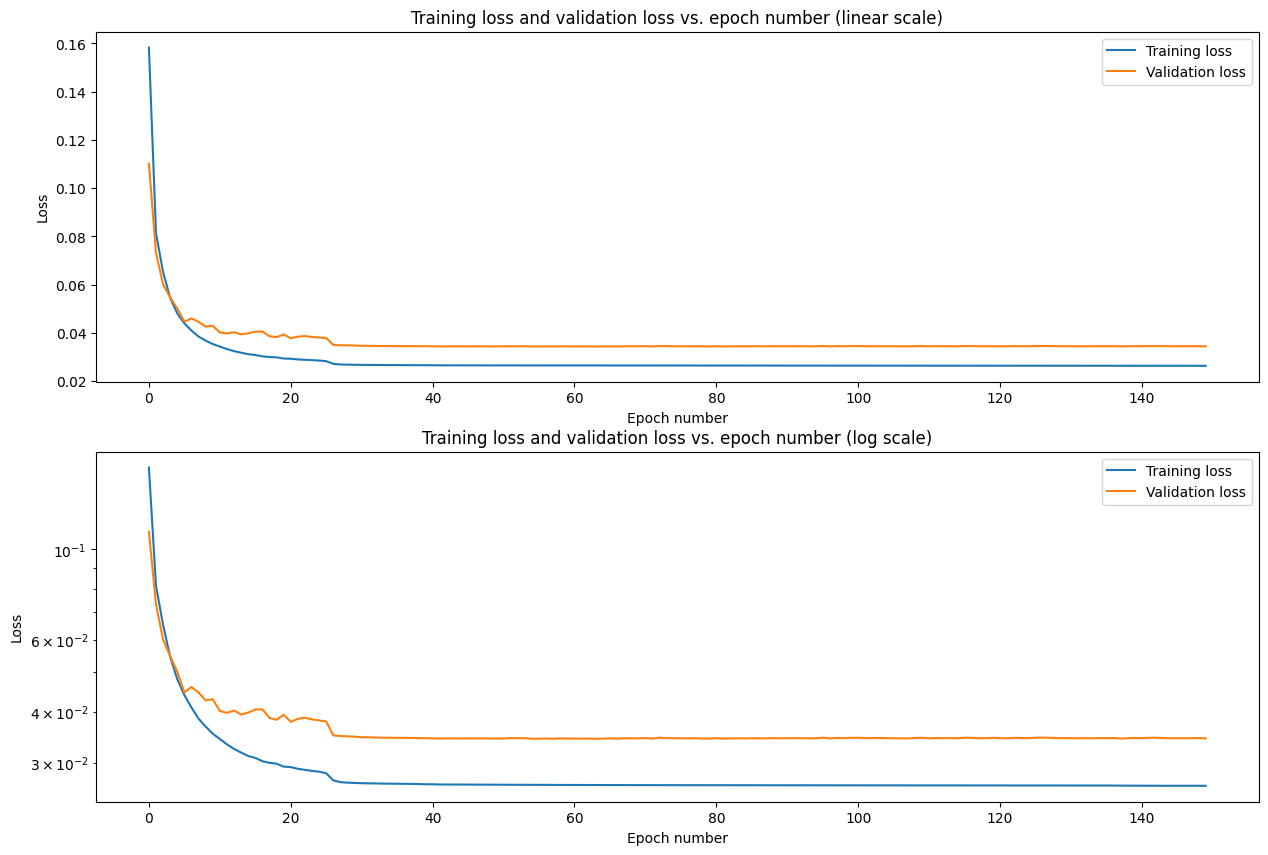

In [10]:
#@markdown ##Play the cell to show a plot of training errors vs. epoch number


lossDataFromCSV = []
vallossDataFromCSV = []

with open(os.path.join(QC_model_path,'Quality Control/training_evaluation.csv'),'r') as csvfile:
    csvRead = csv.reader(csvfile, delimiter=',')
    next(csvRead)
    for row in csvRead:
      if row:
        lossDataFromCSV.append(float(row[0]))
        vallossDataFromCSV.append(float(row[1]))

epochNumber = range(len(lossDataFromCSV))
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(epochNumber,lossDataFromCSV, label='Training loss')
plt.plot(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(epochNumber,lossDataFromCSV, label='Training loss')
plt.semilogy(epochNumber,vallossDataFromCSV, label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
#plt.savefig(os.path.join(QC_model_path,'Quality Control/lossCurvePlots.png'), bbox_inches='tight', pad_inches=0)
plt.show()



# **6. Using the trained model**

---

<font size = 4>In this section the unseen data is processed using the trained model (in section 4). First, your unseen images are uploaded and prepared for prediction. After that your trained model from section 4 is activated and finally saved into your Google Drive.

## **6.1 Generate image prediction and localizations from unseen dataset**
---

<font size = 4>The current trained model (from section 4.2) can now be used to process images. If you want to use an older model, untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Result_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Data_folder`:** This folder should contain the images that you want to use your trained network on for processing.

<font size = 4>**`Result_folder`:** This folder will contain the found localizations csv.

<font size = 4>**`batch_size`:** This paramter determines how many frames are processed by any single pass on the GPU. A higher `batch_size` will make the prediction faster but will use more GPU memory. If an OutOfMemory (OOM) error occurs, decrease the `batch_size`. **DEFAULT: 4**

<font size = 4>**`threshold`:** This paramter determines threshold for local maxima finding. The value is expected to reside in the range **[0,1]**. A higher `threshold` will result in less localizations. **DEFAULT: 0.1**

<font size = 4>**`neighborhood_size`:** This paramter determines size of the neighborhood within which the prediction needs to be a local maxima in recovery pixels (CCD pixel/upsampling_factor). A high `neighborhood_size` will make the prediction slower and potentially discard nearby localizations. **DEFAULT: 3**

<font size = 4>**`use_local_average`:** This paramter determines whether to locally average the prediction in a 3x3 neighborhood to get the final localizations. If set to **True** it will make inference slightly slower depending on the size of the FOV. **DEFAULT: True**


The test model will be used.
Using local averaging
------------------------------------
Running prediction on: 1502_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


------------------------------------
Running prediction on: 0529_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 0953_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1936_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.06it/s]


------------------------------------
Running prediction on: 1060_test.tif
Input image is 40x120 with 1 frames.


  0%|                                                                                                | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2222_test.tif
Input image is 40x120 with 1 frames.


  0%|                                                                                                | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


------------------------------------
Running prediction on: 2501_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0657_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2736_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 2467_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


------------------------------------
Running prediction on: 2243_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2149_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


------------------------------------
Running prediction on: 0329_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


------------------------------------
Running prediction on: 2147_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 2884_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1749_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 2517_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0817_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.47it/s]


------------------------------------
Running prediction on: 2601_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2788_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1028_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


------------------------------------
Running prediction on: 1433_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1034_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 1443_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


------------------------------------
Running prediction on: 0408_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 2067_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


------------------------------------
Running prediction on: 0159_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 0782_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 1825_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


------------------------------------
Running prediction on: 2871_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


------------------------------------
Running prediction on: 2799_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 0348_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 1361_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]


------------------------------------
Running prediction on: 1342_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1589_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]


------------------------------------
Running prediction on: 2692_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0011_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.49it/s]


------------------------------------
Running prediction on: 0317_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 1975_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2457_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 1263_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2535_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


------------------------------------
Running prediction on: 0888_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2729_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 2940_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 2519_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 0397_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2724_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2211_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0074_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2539_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 1698_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2394_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2607_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1266_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 1639_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.85it/s]


------------------------------------
Running prediction on: 1768_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0837_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1600_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.21it/s]


------------------------------------
Running prediction on: 0182_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0236_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1535_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1004_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2013_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


------------------------------------
Running prediction on: 2312_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2997_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2516_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1690_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


------------------------------------
Running prediction on: 0538_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


------------------------------------
Running prediction on: 2591_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1181_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 1444_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0105_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 1881_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


------------------------------------
Running prediction on: 1427_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0935_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 1057_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1220_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2491_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


------------------------------------
Running prediction on: 2745_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


------------------------------------
Running prediction on: 1474_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1389_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0398_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0569_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


------------------------------------
Running prediction on: 2632_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 1391_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 1506_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2077_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]


------------------------------------
Running prediction on: 1694_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0478_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 1687_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 0053_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2553_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 2930_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2596_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0175_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2470_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2557_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.28it/s]


------------------------------------
Running prediction on: 0624_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1311_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1913_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1357_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2440_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


------------------------------------
Running prediction on: 2684_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1069_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0031_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


------------------------------------
Running prediction on: 0419_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1065_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


------------------------------------
Running prediction on: 1325_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2045_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1631_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 0961_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2473_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


------------------------------------
Running prediction on: 1714_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0723_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2777_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0763_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1517_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


------------------------------------
Running prediction on: 2664_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 0135_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1794_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


------------------------------------
Running prediction on: 2002_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


------------------------------------
Running prediction on: 2382_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


------------------------------------
Running prediction on: 2995_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1905_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 1245_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2974_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


------------------------------------
Running prediction on: 0975_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2102_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2444_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 3000_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2137_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


------------------------------------
Running prediction on: 1691_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.73it/s]


------------------------------------
Running prediction on: 0902_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 1459_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1934_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2879_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0769_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2528_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1919_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0556_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0608_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1773_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2643_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1294_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]


------------------------------------
Running prediction on: 0469_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1358_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1695_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0755_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0273_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 1298_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 0491_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2573_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.89it/s]


------------------------------------
Running prediction on: 0025_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0270_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2688_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0052_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 1672_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


------------------------------------
Running prediction on: 2985_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0944_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]

------------------------------------
Running prediction on: 1449_test.tif


Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


------------------------------------
Running prediction on: 0371_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


------------------------------------
Running prediction on: 2960_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0405_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 1839_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


------------------------------------
Running prediction on: 1859_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0048_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2449_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.85it/s]


------------------------------------
Running prediction on: 1239_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1343_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


------------------------------------
Running prediction on: 2339_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1949_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 1925_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2537_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1246_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0638_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0826_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1816_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.93it/s]


------------------------------------
Running prediction on: 1863_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1470_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1692_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0110_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2807_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


------------------------------------
Running prediction on: 2395_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


------------------------------------
Running prediction on: 1864_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0911_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0653_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 0290_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


------------------------------------
Running prediction on: 2289_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


------------------------------------
Running prediction on: 1436_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 0978_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0540_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1086_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


------------------------------------
Running prediction on: 1076_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0323_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2901_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


------------------------------------
Running prediction on: 1355_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 0492_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


------------------------------------
Running prediction on: 2711_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 2121_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0695_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


------------------------------------
Running prediction on: 0162_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.01it/s]


------------------------------------
Running prediction on: 2378_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


------------------------------------
Running prediction on: 2791_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


------------------------------------
Running prediction on: 0552_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2376_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1658_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


------------------------------------
Running prediction on: 1957_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 2301_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


------------------------------------
Running prediction on: 1310_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2402_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0772_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1655_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2498_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1452_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2027_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 2178_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2094_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1604_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2561_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 0210_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2434_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 0400_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.53it/s]


------------------------------------
Running prediction on: 1703_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 1647_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0683_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2951_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 1448_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1336_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


------------------------------------
Running prediction on: 1198_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 1151_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 1955_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2429_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0287_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0426_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


------------------------------------
Running prediction on: 0749_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2932_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2903_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 0454_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


------------------------------------
Running prediction on: 2081_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


------------------------------------
Running prediction on: 1683_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 1920_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 1196_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1854_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1139_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2150_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


------------------------------------
Running prediction on: 0875_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1806_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.11it/s]


------------------------------------
Running prediction on: 2439_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1275_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0250_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2485_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2792_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0225_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2937_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0659_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0622_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1434_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0083_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0489_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2230_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0282_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


------------------------------------
Running prediction on: 1793_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2098_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 2700_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2804_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 2707_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 1818_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 0797_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0448_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1891_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 1282_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0278_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 0943_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.92it/s]


------------------------------------
Running prediction on: 1570_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1555_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2468_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1596_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2666_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2689_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]


------------------------------------
Running prediction on: 1512_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


------------------------------------
Running prediction on: 1644_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.94it/s]


------------------------------------
Running prediction on: 0575_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 0658_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2189_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


------------------------------------
Running prediction on: 1801_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1943_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


------------------------------------
Running prediction on: 2898_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2512_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1340_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2719_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2197_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2025_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1143_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


------------------------------------
Running prediction on: 2125_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0677_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1411_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1332_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2132_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


------------------------------------
Running prediction on: 2069_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2731_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


------------------------------------
Running prediction on: 0302_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0064_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1314_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 2706_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 2276_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 1221_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2862_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 1175_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0122_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2448_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2839_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2281_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


------------------------------------
Running prediction on: 2737_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2609_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0263_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


------------------------------------
Running prediction on: 2332_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


------------------------------------
Running prediction on: 0700_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


------------------------------------
Running prediction on: 0685_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1542_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 2612_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 0784_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2466_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 0584_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.60it/s]


------------------------------------
Running prediction on: 1675_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2673_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1339_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0262_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 2010_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 2502_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2928_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0205_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1852_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1172_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2941_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1750_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1492_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1112_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 0587_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0862_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


------------------------------------
Running prediction on: 1649_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2858_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0858_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 0137_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2841_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


------------------------------------
Running prediction on: 2943_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2151_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 1404_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1001_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0905_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]


------------------------------------
Running prediction on: 1072_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1809_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


------------------------------------
Running prediction on: 1847_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1821_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2919_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


------------------------------------
Running prediction on: 1603_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


------------------------------------
Running prediction on: 0729_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


------------------------------------
Running prediction on: 2633_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0909_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 1306_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


------------------------------------
Running prediction on: 2649_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 1341_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 2159_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


------------------------------------
Running prediction on: 0716_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


------------------------------------
Running prediction on: 1053_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


------------------------------------
Running prediction on: 1713_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1914_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0414_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 1595_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0391_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0857_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0711_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2581_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2886_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0423_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2872_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0687_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 0848_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0600_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.29it/s]


------------------------------------
Running prediction on: 2953_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0392_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2385_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 1607_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0063_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2825_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.70it/s]


------------------------------------
Running prediction on: 2975_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1528_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 2393_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0960_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0766_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.20it/s]


------------------------------------
Running prediction on: 2522_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


------------------------------------
Running prediction on: 1413_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2443_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2847_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


------------------------------------
Running prediction on: 1409_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0455_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]


------------------------------------
Running prediction on: 2837_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0284_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 2542_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0184_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0963_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 2642_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


------------------------------------
Running prediction on: 1304_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0824_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


------------------------------------
Running prediction on: 1047_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 1637_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 0997_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2938_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 1279_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 2970_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.60it/s]


------------------------------------
Running prediction on: 1588_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0896_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0791_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0244_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1354_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


------------------------------------
Running prediction on: 0520_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0640_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1652_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


------------------------------------
Running prediction on: 2483_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2262_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


------------------------------------
Running prediction on: 2106_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


------------------------------------
Running prediction on: 2239_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1417_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


------------------------------------
Running prediction on: 0320_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 1755_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


------------------------------------
Running prediction on: 2585_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2459_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1518_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2562_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1425_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.68it/s]


------------------------------------
Running prediction on: 1051_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2819_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 1724_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


------------------------------------
Running prediction on: 2241_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


------------------------------------
Running prediction on: 1519_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 2865_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1501_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1428_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2056_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 0232_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 0628_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


------------------------------------
Running prediction on: 1812_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1149_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.01it/s]


------------------------------------
Running prediction on: 2157_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0634_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2303_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2361_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 0642_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2038_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0326_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2364_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2345_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1482_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0026_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 0890_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


------------------------------------
Running prediction on: 2880_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1764_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


------------------------------------
Running prediction on: 0805_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1879_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2653_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.64it/s]


------------------------------------
Running prediction on: 0712_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 0357_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


------------------------------------
Running prediction on: 2957_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0833_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 1115_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


------------------------------------
Running prediction on: 2299_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0513_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2780_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0335_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 1559_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


------------------------------------
Running prediction on: 1077_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2409_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 1776_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.97it/s]


------------------------------------
Running prediction on: 1815_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


------------------------------------
Running prediction on: 0873_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1986_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 0988_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


------------------------------------
Running prediction on: 2059_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0044_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2342_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


------------------------------------
Running prediction on: 2166_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0431_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 2499_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0181_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 0874_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 0812_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0215_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0521_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0466_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 2856_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2813_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


------------------------------------
Running prediction on: 1580_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1419_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1200_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1625_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2092_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


------------------------------------
Running prediction on: 2224_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1597_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2978_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1733_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


------------------------------------
Running prediction on: 1883_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1334_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1785_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 2234_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2066_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


------------------------------------
Running prediction on: 0726_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2806_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1752_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


------------------------------------
Running prediction on: 2204_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2305_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


------------------------------------
Running prediction on: 2327_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


------------------------------------
Running prediction on: 1583_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0947_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0213_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


------------------------------------
Running prediction on: 1745_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


------------------------------------
Running prediction on: 1702_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 2497_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 1164_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1094_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


------------------------------------
Running prediction on: 0022_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0276_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 1732_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1712_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2255_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


------------------------------------
Running prediction on: 0894_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 1960_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1038_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2268_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1686_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2458_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1387_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 2477_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 0345_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1586_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0929_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.78it/s]


------------------------------------
Running prediction on: 0969_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2996_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2417_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2313_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1759_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0734_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2486_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0594_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0798_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2547_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1861_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 1008_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


------------------------------------
Running prediction on: 0438_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1837_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1299_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.89it/s]


------------------------------------
Running prediction on: 0313_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.98it/s]


------------------------------------
Running prediction on: 0795_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


------------------------------------
Running prediction on: 1371_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


------------------------------------
Running prediction on: 0770_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1090_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


------------------------------------
Running prediction on: 2866_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1353_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 2949_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


------------------------------------
Running prediction on: 2407_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


------------------------------------
Running prediction on: 1709_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 0432_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1673_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1075_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2916_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 1777_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2795_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0900_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2226_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0413_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2478_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2403_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1111_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0428_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0429_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


------------------------------------
Running prediction on: 0176_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0656_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2685_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0297_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 1994_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1544_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1521_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2039_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0934_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0308_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0368_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


------------------------------------
Running prediction on: 0750_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.25it/s]


------------------------------------
Running prediction on: 2811_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 0293_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1012_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 0369_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.94it/s]


------------------------------------
Running prediction on: 0468_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 0188_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2981_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1467_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2990_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 2530_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 0088_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


------------------------------------
Running prediction on: 2200_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2983_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1590_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1540_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 0574_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0362_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2645_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2215_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2007_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1473_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1993_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2475_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2828_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1006_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2821_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2820_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


------------------------------------
Running prediction on: 0582_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2881_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2733_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2141_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 2681_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1293_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0126_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


------------------------------------
Running prediction on: 0925_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1484_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2977_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0168_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1059_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


------------------------------------
Running prediction on: 0358_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1593_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2778_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


------------------------------------
Running prediction on: 1797_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 2496_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


------------------------------------
Running prediction on: 0359_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1347_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 1472_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2492_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0636_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


------------------------------------
Running prediction on: 2923_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


------------------------------------
Running prediction on: 1368_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2661_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0185_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.23it/s]


------------------------------------
Running prediction on: 0274_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 1405_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2414_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.48it/s]


------------------------------------
Running prediction on: 2453_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0089_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.55it/s]


------------------------------------
Running prediction on: 0354_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2947_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1895_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2603_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0336_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.85it/s]


------------------------------------
Running prediction on: 0012_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0964_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 2410_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 0860_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1213_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


------------------------------------
Running prediction on: 1903_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1108_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2600_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2739_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1781_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


------------------------------------
Running prediction on: 2212_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2863_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0404_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0514_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2599_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


------------------------------------
Running prediction on: 0992_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2758_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1980_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2375_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 2227_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2521_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 2538_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 1125_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2691_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2524_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2570_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


------------------------------------
Running prediction on: 0245_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2247_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


------------------------------------
Running prediction on: 0139_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1118_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2369_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0501_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 0989_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1019_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0537_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2005_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2889_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0472_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2093_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 1693_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


------------------------------------
Running prediction on: 2488_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0887_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


------------------------------------
Running prediction on: 0298_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


------------------------------------
Running prediction on: 2611_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1612_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.21it/s]


------------------------------------
Running prediction on: 1159_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 2122_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.47it/s]


------------------------------------
Running prediction on: 2329_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1496_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1838_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


------------------------------------
Running prediction on: 2330_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2296_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2170_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1984_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


------------------------------------
Running prediction on: 1996_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


------------------------------------
Running prediction on: 0447_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2019_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 2474_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


------------------------------------
Running prediction on: 2295_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 1152_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


------------------------------------
Running prediction on: 2812_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


------------------------------------
Running prediction on: 0886_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0927_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 1926_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 0337_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


------------------------------------
Running prediction on: 1933_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0380_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 0705_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2139_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 0195_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0958_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0100_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1978_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2181_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2874_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0237_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 0043_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2360_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0607_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.79it/s]


------------------------------------
Running prediction on: 0551_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2927_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]


------------------------------------
Running prediction on: 1367_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2851_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1789_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1942_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


------------------------------------
Running prediction on: 0169_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 0006_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0439_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 0515_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1446_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


------------------------------------
Running prediction on: 2610_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0563_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1295_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.16it/s]


------------------------------------
Running prediction on: 0698_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0385_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


------------------------------------
Running prediction on: 0605_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0948_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1817_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 1153_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 2051_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


------------------------------------
Running prediction on: 2160_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0104_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 2716_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 1303_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


------------------------------------
Running prediction on: 2727_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1254_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 0002_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 0678_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0170_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.29it/s]


------------------------------------
Running prediction on: 1708_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2162_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2816_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1447_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1168_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


------------------------------------
Running prediction on: 0785_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0171_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2180_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2913_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


------------------------------------
Running prediction on: 1007_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.73it/s]


------------------------------------
Running prediction on: 2801_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]


------------------------------------
Running prediction on: 2148_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2187_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 2934_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2892_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


------------------------------------
Running prediction on: 2637_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0338_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0676_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2293_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1721_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.91it/s]


------------------------------------
Running prediction on: 2924_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 1585_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.33it/s]


------------------------------------
Running prediction on: 1954_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.87it/s]


------------------------------------
Running prediction on: 1136_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1197_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


------------------------------------
Running prediction on: 2647_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


------------------------------------
Running prediction on: 2554_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


------------------------------------
Running prediction on: 1910_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1270_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2462_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


------------------------------------
Running prediction on: 2852_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0828_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 0609_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 1788_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


------------------------------------
Running prediction on: 1132_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1179_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


------------------------------------
Running prediction on: 2134_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1685_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 1983_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 2238_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1884_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0928_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2064_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0511_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0714_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1123_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0049_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1480_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 0121_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 1142_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


------------------------------------
Running prediction on: 1096_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2256_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 2219_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1185_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0071_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1951_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2032_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0956_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2044_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2613_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.92it/s]


------------------------------------
Running prediction on: 2118_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2904_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.77it/s]


------------------------------------
Running prediction on: 2639_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2054_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0704_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


------------------------------------
Running prediction on: 1890_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2310_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


------------------------------------
Running prediction on: 2963_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2334_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1398_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.44it/s]


------------------------------------
Running prediction on: 0871_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2540_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0984_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


------------------------------------
Running prediction on: 1156_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.44it/s]


------------------------------------
Running prediction on: 0872_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1023_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0864_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2323_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2772_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 0206_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1982_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1790_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 1850_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1116_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1392_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0378_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0406_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2695_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 2503_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.48it/s]


------------------------------------
Running prediction on: 2754_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0899_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2217_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0144_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 1273_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0957_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 1967_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2746_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1494_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0072_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1037_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2205_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


------------------------------------
Running prediction on: 0216_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1244_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1868_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1610_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


------------------------------------
Running prediction on: 1277_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0410_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2722_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 2849_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1157_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


------------------------------------
Running prediction on: 1757_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2427_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


------------------------------------
Running prediction on: 1407_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0977_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


------------------------------------
Running prediction on: 2914_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2419_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


------------------------------------
Running prediction on: 2352_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 0464_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1908_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


------------------------------------
Running prediction on: 1018_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2911_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1453_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1722_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2979_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


------------------------------------
Running prediction on: 2220_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2755_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1493_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2460_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


------------------------------------
Running prediction on: 1974_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


------------------------------------
Running prediction on: 0231_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1547_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2674_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2192_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0157_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


------------------------------------
Running prediction on: 2126_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0288_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1178_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1174_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2018_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.79it/s]


------------------------------------
Running prediction on: 2835_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


------------------------------------
Running prediction on: 0993_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0390_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 0703_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0279_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


------------------------------------
Running prediction on: 0814_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1016_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1030_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1242_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0436_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


------------------------------------
Running prediction on: 2749_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 1576_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


------------------------------------
Running prediction on: 2500_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0277_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


------------------------------------
Running prediction on: 1485_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 1826_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 0832_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2882_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0580_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.31it/s]


------------------------------------
Running prediction on: 1664_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1160_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0342_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0668_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0045_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


------------------------------------
Running prediction on: 2675_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1979_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 2174_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0735_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


------------------------------------
Running prediction on: 0186_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


------------------------------------
Running prediction on: 1718_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 0675_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0623_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 2662_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1352_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.79it/s]


------------------------------------
Running prediction on: 1258_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1481_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2877_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2273_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1478_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


------------------------------------
Running prediction on: 1780_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


------------------------------------
Running prediction on: 0796_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0395_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.26it/s]


------------------------------------
Running prediction on: 2939_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 2172_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


------------------------------------
Running prediction on: 0099_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0546_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 1900_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1851_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 0843_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


------------------------------------
Running prediction on: 2574_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0351_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.40it/s]


------------------------------------
Running prediction on: 1322_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0579_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.07it/s]


------------------------------------
Running prediction on: 2290_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2461_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1101_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 2259_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2964_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.86it/s]


------------------------------------
Running prediction on: 0669_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0003_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 1770_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 0976_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0010_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


------------------------------------
Running prediction on: 0783_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0533_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 2520_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0846_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.79it/s]


------------------------------------
Running prediction on: 2597_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.82it/s]


------------------------------------
Running prediction on: 1962_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1999_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2994_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2099_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2967_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


------------------------------------
Running prediction on: 2870_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 1963_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 0219_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0421_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2714_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


------------------------------------
Running prediction on: 1177_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


------------------------------------
Running prediction on: 0800_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2358_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1572_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 1526_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


------------------------------------
Running prediction on: 0183_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2479_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1742_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0179_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 0671_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.86it/s]


------------------------------------
Running prediction on: 0280_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2270_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.57it/s]


------------------------------------
Running prediction on: 2194_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0123_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


------------------------------------
Running prediction on: 2383_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0412_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2071_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


------------------------------------
Running prediction on: 2559_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 1591_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


------------------------------------
Running prediction on: 2482_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1835_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2328_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 2694_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2322_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


------------------------------------
Running prediction on: 0626_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1082_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0158_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2396_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


------------------------------------
Running prediction on: 2401_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


------------------------------------
Running prediction on: 2291_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1349_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2183_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0892_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0475_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


------------------------------------
Running prediction on: 1656_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0309_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2279_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1985_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1188_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


------------------------------------
Running prediction on: 2318_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 0020_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 0155_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1137_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 1044_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


------------------------------------
Running prediction on: 1674_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2331_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2078_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0433_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2436_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


------------------------------------
Running prediction on: 2618_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0367_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


------------------------------------
Running prediction on: 2876_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0165_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


------------------------------------
Running prediction on: 1080_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 2130_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0258_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1098_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1931_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


------------------------------------
Running prediction on: 0802_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2455_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2155_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2050_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 1549_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.13it/s]


------------------------------------
Running prediction on: 0545_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0102_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2793_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2720_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


------------------------------------
Running prediction on: 2249_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


------------------------------------
Running prediction on: 2203_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 2781_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1318_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2650_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2598_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


------------------------------------
Running prediction on: 1209_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0483_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0192_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1315_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2011_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.62it/s]


------------------------------------
Running prediction on: 1278_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


------------------------------------
Running prediction on: 1191_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1064_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2152_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 1216_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


------------------------------------
Running prediction on: 0561_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2043_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0145_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 2640_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 1836_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


------------------------------------
Running prediction on: 0777_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2022_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


------------------------------------
Running prediction on: 1104_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2261_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


------------------------------------
Running prediction on: 2156_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0114_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 2917_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1740_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1853_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.62it/s]


------------------------------------
Running prediction on: 2140_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1284_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 0980_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0830_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1738_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.09it/s]


------------------------------------
Running prediction on: 1469_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0646_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0733_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2850_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


------------------------------------
Running prediction on: 0422_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


------------------------------------
Running prediction on: 0452_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0306_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0256_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 0751_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1799_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


------------------------------------
Running prediction on: 2233_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1305_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0465_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 1262_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2717_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


------------------------------------
Running prediction on: 1911_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.88it/s]


------------------------------------
Running prediction on: 1995_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2113_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1414_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 0332_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


------------------------------------
Running prediction on: 1351_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 2076_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


------------------------------------
Running prediction on: 0462_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0966_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1533_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 1736_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0706_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


------------------------------------
Running prediction on: 1537_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 1184_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


------------------------------------
Running prediction on: 2936_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0893_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0117_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0488_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1335_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.85it/s]


------------------------------------
Running prediction on: 2454_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2584_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 1107_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1014_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1663_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.68it/s]


------------------------------------
Running prediction on: 1189_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2857_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2186_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1468_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 1307_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


------------------------------------
Running prediction on: 1617_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0728_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2888_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0333_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0005_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


------------------------------------
Running prediction on: 1061_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1990_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1719_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2298_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1288_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.11it/s]


------------------------------------
Running prediction on: 1665_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


------------------------------------
Running prediction on: 2100_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1710_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 1471_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0305_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


------------------------------------
Running prediction on: 0819_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0722_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1326_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2563_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0132_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.58it/s]


------------------------------------
Running prediction on: 1403_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2286_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


------------------------------------
Running prediction on: 1783_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2899_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.20it/s]


------------------------------------
Running prediction on: 1553_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1487_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1751_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 1622_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 2437_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.35it/s]


------------------------------------
Running prediction on: 1048_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0021_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1323_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2907_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0528_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.15it/s]


------------------------------------
Running prediction on: 1820_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0760_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1129_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1964_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 0823_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.00it/s]


------------------------------------
Running prediction on: 1578_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1045_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 1795_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 2766_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1192_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


------------------------------------
Running prediction on: 2277_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2114_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 1874_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1779_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2842_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


------------------------------------
Running prediction on: 0859_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]


------------------------------------
Running prediction on: 2565_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2108_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0811_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 0007_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


------------------------------------
Running prediction on: 0550_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0629_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 2560_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2669_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 2658_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.09it/s]


------------------------------------
Running prediction on: 1410_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1124_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


------------------------------------
Running prediction on: 2416_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 2808_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.62it/s]


------------------------------------
Running prediction on: 1525_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1860_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1155_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2179_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0617_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


------------------------------------
Running prediction on: 1463_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2489_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2568_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1688_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0319_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.39it/s]


------------------------------------
Running prediction on: 2908_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 0868_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0781_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 1689_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 2306_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2337_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2091_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0744_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2012_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1845_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


------------------------------------
Running prediction on: 2551_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2344_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1830_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1483_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0775_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.94it/s]


------------------------------------
Running prediction on: 1267_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]


------------------------------------
Running prediction on: 2307_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


------------------------------------
Running prediction on: 1238_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1876_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 1976_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


------------------------------------
Running prediction on: 2373_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]


------------------------------------
Running prediction on: 2506_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 2317_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 2696_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1040_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


------------------------------------
Running prediction on: 0721_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2399_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


------------------------------------
Running prediction on: 0985_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2869_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 0932_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2950_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0304_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1020_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2750_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


------------------------------------
Running prediction on: 0075_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 1832_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 0571_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2741_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1252_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


------------------------------------
Running prediction on: 0505_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1312_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0373_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0774_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 2544_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.93it/s]


------------------------------------
Running prediction on: 1451_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0079_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2302_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2759_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 1594_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.54it/s]


------------------------------------
Running prediction on: 1150_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1055_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0023_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2508_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0310_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


------------------------------------
Running prediction on: 1268_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


------------------------------------
Running prediction on: 0541_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2885_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1941_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 0620_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


------------------------------------
Running prediction on: 2708_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 1848_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2366_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 2787_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2341_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


------------------------------------
Running prediction on: 0411_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0082_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


------------------------------------
Running prediction on: 1292_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1089_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


------------------------------------
Running prediction on: 0360_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1021_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


------------------------------------
Running prediction on: 1316_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


------------------------------------
Running prediction on: 1532_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0829_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


------------------------------------
Running prediction on: 2809_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1378_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1605_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1500_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2146_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


------------------------------------
Running prediction on: 2744_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 2490_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 0998_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1365_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


------------------------------------
Running prediction on: 1831_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


------------------------------------
Running prediction on: 0590_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]


------------------------------------
Running prediction on: 1290_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 0758_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1843_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1680_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.82it/s]


------------------------------------
Running prediction on: 1042_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1767_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2061_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0291_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2177_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


------------------------------------
Running prediction on: 2846_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


------------------------------------
Running prediction on: 1907_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1359_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2008_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2933_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


------------------------------------
Running prediction on: 1070_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


------------------------------------
Running prediction on: 2315_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


------------------------------------
Running prediction on: 0389_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 0202_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0532_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


------------------------------------
Running prediction on: 0387_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 1904_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


------------------------------------
Running prediction on: 2776_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0955_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


------------------------------------
Running prediction on: 1379_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 2124_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 0401_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


------------------------------------
Running prediction on: 1219_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.43it/s]


------------------------------------
Running prediction on: 2606_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


------------------------------------
Running prediction on: 1539_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1477_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1128_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2372_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2764_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


------------------------------------
Running prediction on: 2593_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1327_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 2543_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0615_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 0904_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 0856_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0265_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1243_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0271_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0576_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


------------------------------------
Running prediction on: 0627_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0682_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1609_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1865_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0461_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


------------------------------------
Running prediction on: 1536_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.17it/s]


------------------------------------
Running prediction on: 0228_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1226_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2438_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1766_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


------------------------------------
Running prediction on: 1420_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2853_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2608_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2426_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2738_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.91it/s]


------------------------------------
Running prediction on: 1893_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2254_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


------------------------------------
Running prediction on: 0568_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 0379_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


------------------------------------
Running prediction on: 2009_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0384_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 1344_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 1587_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1271_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


------------------------------------
Running prediction on: 2594_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2252_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2480_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 2910_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0946_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.37it/s]


------------------------------------
Running prediction on: 2287_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0267_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2648_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 1739_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 0822_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.89it/s]


------------------------------------
Running prediction on: 1324_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1844_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2713_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0211_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2037_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]


------------------------------------
Running prediction on: 1508_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0324_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1260_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0684_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2536_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.49it/s]


------------------------------------
Running prediction on: 2026_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.89it/s]


------------------------------------
Running prediction on: 1386_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0301_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1804_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 0307_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


------------------------------------
Running prediction on: 2495_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1050_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 2052_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0069_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2335_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


------------------------------------
Running prediction on: 0441_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1556_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


------------------------------------
Running prediction on: 0613_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1162_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


------------------------------------
Running prediction on: 1748_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0853_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


------------------------------------
Running prediction on: 2036_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2962_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2832_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


------------------------------------
Running prediction on: 0036_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2472_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2308_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1772_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1381_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.10it/s]


------------------------------------
Running prediction on: 0522_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1147_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2484_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2623_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]


------------------------------------
Running prediction on: 0314_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.77it/s]


------------------------------------
Running prediction on: 0409_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 1450_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0068_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2201_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1615_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.00it/s]


------------------------------------
Running prediction on: 1102_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0246_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2827_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1058_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2365_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


------------------------------------
Running prediction on: 0187_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


------------------------------------
Running prediction on: 0560_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 1131_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0226_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.84it/s]


------------------------------------
Running prediction on: 1066_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]


------------------------------------
Running prediction on: 2184_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1141_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0120_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1204_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1671_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


------------------------------------
Running prediction on: 2167_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0146_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


------------------------------------
Running prediction on: 0420_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0047_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


------------------------------------
Running prediction on: 0661_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1782_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


------------------------------------
Running prediction on: 1206_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 0042_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 0877_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


------------------------------------
Running prediction on: 2794_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 1356_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1460_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 0090_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1697_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.93it/s]


------------------------------------
Running prediction on: 2089_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1486_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 1514_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 0460_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 2476_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


------------------------------------
Running prediction on: 1286_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0641_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0098_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1366_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1662_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


------------------------------------
Running prediction on: 0715_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1660_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0771_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1716_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2629_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


------------------------------------
Running prediction on: 0631_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 0330_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0577_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 1970_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 1320_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


------------------------------------
Running prediction on: 0632_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0635_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0633_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0259_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0201_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.49it/s]


------------------------------------
Running prediction on: 0055_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2757_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.58it/s]


------------------------------------
Running prediction on: 1824_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 0643_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


------------------------------------
Running prediction on: 1636_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 2253_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


------------------------------------
Running prediction on: 2655_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


------------------------------------
Running prediction on: 1207_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0254_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


------------------------------------
Running prediction on: 0697_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 1541_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0299_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 0647_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0190_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


------------------------------------
Running prediction on: 0585_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0788_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2782_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0091_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 2636_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


------------------------------------
Running prediction on: 2818_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


------------------------------------
Running prediction on: 0349_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1233_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 1360_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1516_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


------------------------------------
Running prediction on: 0881_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0028_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1629_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 2575_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1898_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


------------------------------------
Running prediction on: 0353_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


------------------------------------
Running prediction on: 1567_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0350_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2952_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


------------------------------------
Running prediction on: 2709_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


------------------------------------
Running prediction on: 1791_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 0033_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


------------------------------------
Running prediction on: 2840_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1959_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1965_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.30it/s]


------------------------------------
Running prediction on: 0294_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1170_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


------------------------------------
Running prediction on: 0519_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2080_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


------------------------------------
Running prediction on: 0035_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1210_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 1915_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 1729_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.47it/s]


------------------------------------
Running prediction on: 0737_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


------------------------------------
Running prediction on: 0056_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1350_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2493_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1400_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2976_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 0564_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


------------------------------------
Running prediction on: 1385_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0818_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1052_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.68it/s]


------------------------------------
Running prediction on: 1231_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.45it/s]


------------------------------------
Running prediction on: 1031_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1558_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1095_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0954_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 0399_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 0163_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1901_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0915_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0606_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2359_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]


------------------------------------
Running prediction on: 0093_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 2196_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1296_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 0897_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.43it/s]


------------------------------------
Running prediction on: 0610_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2446_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 0463_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.84it/s]


------------------------------------
Running prediction on: 1584_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2095_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


------------------------------------
Running prediction on: 1787_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2420_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 1490_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


------------------------------------
Running prediction on: 1505_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1193_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 2622_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


------------------------------------
Running prediction on: 1735_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 2823_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0821_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2549_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2143_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


------------------------------------
Running prediction on: 2023_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1611_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 1527_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1362_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0328_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]


------------------------------------
Running prediction on: 0655_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 0085_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


------------------------------------
Running prediction on: 0602_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


------------------------------------
Running prediction on: 2558_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 2346_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


------------------------------------
Running prediction on: 0549_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 2751_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1078_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1551_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 1432_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


------------------------------------
Running prediction on: 0746_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1569_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2679_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2127_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0096_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


------------------------------------
Running prediction on: 1269_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1228_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1024_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 0527_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0242_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


------------------------------------
Running prediction on: 1377_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 2992_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 2297_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1182_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2145_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


------------------------------------
Running prediction on: 0534_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


------------------------------------
Running prediction on: 1878_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 1550_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 2285_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.68it/s]


------------------------------------
Running prediction on: 1167_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


------------------------------------
Running prediction on: 2101_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 0665_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 0224_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0786_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


------------------------------------
Running prediction on: 0951_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2961_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1256_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2421_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1203_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


------------------------------------
Running prediction on: 1548_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 1166_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0548_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.87it/s]


------------------------------------
Running prediction on: 1828_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2348_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


------------------------------------
Running prediction on: 2798_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0806_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2246_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0660_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0713_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.09it/s]


------------------------------------
Running prediction on: 0059_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0525_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1810_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2103_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0679_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 0127_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 1083_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 0453_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1869_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1010_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


------------------------------------
Running prediction on: 0637_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2586_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 0229_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2582_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1802_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


------------------------------------
Running prediction on: 2678_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


------------------------------------
Running prediction on: 0709_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1402_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1119_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


------------------------------------
Running prediction on: 0816_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


------------------------------------
Running prediction on: 2925_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 2154_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2836_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1800_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


------------------------------------
Running prediction on: 1956_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 0103_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0933_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 2774_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0536_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.05it/s]


------------------------------------
Running prediction on: 1769_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2687_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0747_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.00it/s]


------------------------------------
Running prediction on: 2769_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0808_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


------------------------------------
Running prediction on: 2240_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1743_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1289_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2258_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2765_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


------------------------------------
Running prediction on: 1928_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 1093_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0526_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1250_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2355_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


------------------------------------
Running prediction on: 1503_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1255_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 2659_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2316_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2991_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


------------------------------------
Running prediction on: 2133_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 1571_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2265_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0645_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1110_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


------------------------------------
Running prediction on: 0106_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


------------------------------------
Running prediction on: 1641_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 0374_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 2589_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


------------------------------------
Running prediction on: 0863_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.79it/s]


------------------------------------
Running prediction on: 2723_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 2464_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 1614_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2088_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


------------------------------------
Running prediction on: 1945_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2834_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0361_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 1998_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1598_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


------------------------------------
Running prediction on: 2015_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2718_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1981_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


------------------------------------
Running prediction on: 1834_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1384_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


------------------------------------
Running prediction on: 1552_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1529_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0095_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0651_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0884_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


------------------------------------
Running prediction on: 2165_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0101_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1546_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 2278_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 0878_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


------------------------------------
Running prediction on: 0241_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2725_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0898_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0377_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 0530_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.33it/s]


------------------------------------
Running prediction on: 2556_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 1199_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 1253_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0801_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0402_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


------------------------------------
Running prediction on: 0841_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


------------------------------------
Running prediction on: 2389_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0589_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 2351_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


------------------------------------
Running prediction on: 1621_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


------------------------------------
Running prediction on: 2033_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.41it/s]


------------------------------------
Running prediction on: 0870_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1046_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1681_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


------------------------------------
Running prediction on: 2175_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1422_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0204_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2116_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2085_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.13it/s]


------------------------------------
Running prediction on: 2494_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 1280_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1416_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.18it/s]


------------------------------------
Running prediction on: 0197_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2652_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]


------------------------------------
Running prediction on: 1247_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0442_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0203_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


------------------------------------
Running prediction on: 1897_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1944_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]


------------------------------------
Running prediction on: 1819_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2760_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0234_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0341_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2614_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


------------------------------------
Running prediction on: 0717_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0417_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2859_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 2620_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1003_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.44it/s]


------------------------------------
Running prediction on: 2705_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 0807_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 0517_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0702_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2062_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


------------------------------------
Running prediction on: 2855_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]


------------------------------------
Running prediction on: 1000_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2016_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0809_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


------------------------------------
Running prediction on: 0444_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


------------------------------------
Running prediction on: 2242_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


------------------------------------
Running prediction on: 2105_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 2775_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1074_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


------------------------------------
Running prediction on: 1369_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 2752_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0970_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 2891_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0161_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.39it/s]


------------------------------------
Running prediction on: 2824_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1669_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 0129_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.89it/s]


------------------------------------
Running prediction on: 1169_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2634_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


------------------------------------
Running prediction on: 1510_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 0842_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1653_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0440_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2900_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


------------------------------------
Running prediction on: 1067_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2514_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0789_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0835_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2325_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


------------------------------------
Running prediction on: 1628_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 1272_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0153_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 2966_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0087_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


------------------------------------
Running prediction on: 2090_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 1330_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0150_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


------------------------------------
Running prediction on: 1871_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1236_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


------------------------------------
Running prediction on: 0861_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


------------------------------------
Running prediction on: 1676_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 1929_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 1498_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


------------------------------------
Running prediction on: 2055_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.25it/s]


------------------------------------
Running prediction on: 2169_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


------------------------------------
Running prediction on: 1966_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 2041_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0296_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 0018_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2796_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 1563_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0820_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 1648_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.70it/s]


------------------------------------
Running prediction on: 0037_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 2042_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 2195_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.90it/s]


------------------------------------
Running prediction on: 1455_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1106_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.83it/s]


------------------------------------
Running prediction on: 0565_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1522_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 0611_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1875_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1734_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


------------------------------------
Running prediction on: 0650_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 1113_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2815_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2405_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0247_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


------------------------------------
Running prediction on: 2424_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2726_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1696_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 2710_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 2075_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.77it/s]


------------------------------------
Running prediction on: 1313_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2418_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1822_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0450_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 0255_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


------------------------------------
Running prediction on: 0867_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


------------------------------------
Running prediction on: 0214_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1575_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


------------------------------------
Running prediction on: 1756_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


------------------------------------
Running prediction on: 0180_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 2400_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 2314_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1062_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1043_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2701_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0753_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1937_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1579_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0724_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0143_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 0891_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0692_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


------------------------------------
Running prediction on: 2982_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2031_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2223_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.25it/s]


------------------------------------
Running prediction on: 2505_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2232_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 0691_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0889_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0547_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2282_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 1912_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0912_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1887_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


------------------------------------
Running prediction on: 2921_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


------------------------------------
Running prediction on: 1230_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 1856_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 0427_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 0134_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1321_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


------------------------------------
Running prediction on: 0688_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 0780_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1049_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0467_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1829_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


------------------------------------
Running prediction on: 1619_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2138_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1737_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0876_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


------------------------------------
Running prediction on: 2381_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


------------------------------------
Running prediction on: 2822_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0696_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0177_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2617_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0869_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2616_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2257_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1654_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 1973_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 1227_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2188_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0910_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 0707_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0009_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2214_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1426_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0424_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2309_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0312_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0029_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0718_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1747_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2428_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.80it/s]


------------------------------------
Running prediction on: 2893_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2988_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1581_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 1015_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0269_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


------------------------------------
Running prediction on: 1302_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.90it/s]


------------------------------------
Running prediction on: 2803_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.85it/s]


------------------------------------
Running prediction on: 1380_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0272_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2264_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 0562_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


------------------------------------
Running prediction on: 2284_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2814_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0844_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 1488_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.45it/s]


------------------------------------
Running prediction on: 1476_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


------------------------------------
Running prediction on: 0553_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0275_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1281_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0388_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]


------------------------------------
Running prediction on: 2433_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


------------------------------------
Running prediction on: 2425_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0986_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1646_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 1418_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2063_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.13it/s]


------------------------------------
Running prediction on: 2404_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.87it/s]


------------------------------------
Running prediction on: 0133_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 1126_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0994_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 1888_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


------------------------------------
Running prediction on: 2294_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1972_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2580_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1475_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1805_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.90it/s]


------------------------------------
Running prediction on: 2894_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0621_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 2682_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 0076_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2435_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.83it/s]


------------------------------------
Running prediction on: 1372_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 0051_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0787_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1953_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2017_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.56it/s]


------------------------------------
Running prediction on: 0498_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 0382_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2283_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0531_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


------------------------------------
Running prediction on: 0067_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 0156_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0792_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 2248_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.72it/s]


------------------------------------
Running prediction on: 0136_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


------------------------------------
Running prediction on: 1727_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 0058_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2883_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 1363_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2545_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]


------------------------------------
Running prediction on: 1620_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1466_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2873_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2046_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 2129_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


------------------------------------
Running prediction on: 1677_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


------------------------------------
Running prediction on: 0172_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 0435_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0149_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0220_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


------------------------------------
Running prediction on: 0588_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 0882_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0164_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1283_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 2784_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.74it/s]


------------------------------------
Running prediction on: 0355_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1952_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2144_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.08it/s]


------------------------------------
Running prediction on: 2207_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1194_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


------------------------------------
Running prediction on: 0701_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1249_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 0476_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0614_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0559_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.01it/s]


------------------------------------
Running prediction on: 1456_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 2347_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2663_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1375_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


------------------------------------
Running prediction on: 1421_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1133_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.84it/s]


------------------------------------
Running prediction on: 2980_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0732_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


------------------------------------
Running prediction on: 0471_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


------------------------------------
Running prediction on: 2564_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 1833_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 0141_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 0124_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


------------------------------------
Running prediction on: 2338_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


------------------------------------
Running prediction on: 0024_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 1348_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2656_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 2572_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 2527_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.95it/s]


------------------------------------
Running prediction on: 2826_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]


------------------------------------
Running prediction on: 0081_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 1154_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0334_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 0062_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


------------------------------------
Running prediction on: 1808_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0142_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1858_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1796_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0592_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.47it/s]


------------------------------------
Running prediction on: 1554_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1084_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0803_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


------------------------------------
Running prediction on: 1457_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2014_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


------------------------------------
Running prediction on: 2619_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2896_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2057_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2909_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0239_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


------------------------------------
Running prediction on: 2471_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2683_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2029_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2958_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


------------------------------------
Running prediction on: 0730_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0318_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 1855_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 1754_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


------------------------------------
Running prediction on: 0942_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.20it/s]


------------------------------------
Running prediction on: 0331_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


------------------------------------
Running prediction on: 1092_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1319_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0347_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0050_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


------------------------------------
Running prediction on: 0644_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 1465_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2735_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 1902_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 0768_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.47it/s]


------------------------------------
Running prediction on: 0285_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.83it/s]


------------------------------------
Running prediction on: 0920_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1489_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1026_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1651_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


------------------------------------
Running prediction on: 1130_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 1523_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1301_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0343_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0148_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


------------------------------------
Running prediction on: 0484_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0097_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


------------------------------------
Running prediction on: 1300_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


------------------------------------
Running prediction on: 2274_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2579_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.32it/s]


------------------------------------
Running prediction on: 2182_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]

------------------------------------


Running prediction on: 2529_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0815_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 0356_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2833_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.59it/s]


------------------------------------
Running prediction on: 0363_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 0794_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1412_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 1715_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


------------------------------------
Running prediction on: 2354_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2202_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 1430_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2112_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.48it/s]


------------------------------------
Running prediction on: 1857_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


------------------------------------
Running prediction on: 2844_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 0901_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0325_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 1599_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2955_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.57it/s]


------------------------------------
Running prediction on: 0539_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 1557_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 1997_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 1117_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1670_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s]


------------------------------------
Running prediction on: 2115_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


------------------------------------
Running prediction on: 2770_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 1561_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2072_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2161_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


------------------------------------
Running prediction on: 2511_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0486_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2357_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2153_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1329_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]


------------------------------------
Running prediction on: 1445_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 1841_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2578_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


------------------------------------
Running prediction on: 0217_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0221_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


------------------------------------
Running prediction on: 2532_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


------------------------------------
Running prediction on: 2986_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 0940_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 1645_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1657_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


------------------------------------
Running prediction on: 0918_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0518_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1393_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0516_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


------------------------------------
Running prediction on: 2657_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2922_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0673_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0418_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


------------------------------------
Running prediction on: 2006_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


------------------------------------
Running prediction on: 0479_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2300_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 0596_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2704_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2817_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


------------------------------------
Running prediction on: 1775_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


------------------------------------
Running prediction on: 2356_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1225_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2020_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1616_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


------------------------------------
Running prediction on: 0393_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]


------------------------------------
Running prediction on: 1424_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 0094_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2028_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1763_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


------------------------------------
Running prediction on: 0681_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1235_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1562_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0260_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2906_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.54it/s]


------------------------------------
Running prediction on: 1601_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0407_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2588_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


------------------------------------
Running prediction on: 2120_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2800_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


------------------------------------
Running prediction on: 0014_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0046_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 2931_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


------------------------------------
Running prediction on: 0107_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0962_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


------------------------------------
Running prediction on: 2003_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2786_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2213_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0813_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


------------------------------------
Running prediction on: 2926_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0938_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.94it/s]


------------------------------------
Running prediction on: 2972_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1063_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


------------------------------------
Running prediction on: 0991_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.83it/s]


------------------------------------
Running prediction on: 2411_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 0593_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0652_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0218_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2712_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


------------------------------------
Running prediction on: 2860_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2715_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 1437_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2431_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 2667_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.86it/s]


------------------------------------
Running prediction on: 2654_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


------------------------------------
Running prediction on: 2868_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


------------------------------------
Running prediction on: 1624_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1390_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2481_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


------------------------------------
Running prediction on: 0013_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 1679_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2721_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 2829_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0757_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]


------------------------------------
Running prediction on: 2377_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1792_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2423_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


------------------------------------
Running prediction on: 2779_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0507_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.70it/s]


------------------------------------
Running prediction on: 0252_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0209_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 1229_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 1560_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0445_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


------------------------------------
Running prediction on: 0344_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0061_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 2236_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0630_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


------------------------------------
Running prediction on: 2555_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2465_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.84it/s]


------------------------------------
Running prediction on: 1753_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2104_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


------------------------------------
Running prediction on: 0741_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.88it/s]


------------------------------------
Running prediction on: 1097_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.45it/s]


------------------------------------
Running prediction on: 2864_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2672_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2680_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 0495_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


------------------------------------
Running prediction on: 0289_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0834_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


------------------------------------
Running prediction on: 2193_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


------------------------------------
Running prediction on: 2209_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0686_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.13it/s]


------------------------------------
Running prediction on: 1602_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.93it/s]


------------------------------------
Running prediction on: 1638_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0240_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 0415_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2237_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.31it/s]


------------------------------------
Running prediction on: 0965_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2621_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1308_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0972_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1346_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]


------------------------------------
Running prediction on: 0731_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2263_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 0557_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.22it/s]


------------------------------------
Running prediction on: 0230_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2158_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


------------------------------------
Running prediction on: 0601_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1333_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 1105_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 0222_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 0648_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


------------------------------------
Running prediction on: 1633_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2119_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 2111_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1971_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


------------------------------------
Running prediction on: 0027_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1022_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1214_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 1771_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


------------------------------------
Running prediction on: 1274_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.57it/s]


------------------------------------
Running prediction on: 2363_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


------------------------------------
Running prediction on: 0524_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0544_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0923_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 2954_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


------------------------------------
Running prediction on: 1397_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1100_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1309_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 0266_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 1109_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.35it/s]


------------------------------------
Running prediction on: 0194_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


------------------------------------
Running prediction on: 2451_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 2267_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 1002_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 1946_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


------------------------------------
Running prediction on: 2677_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 0921_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1383_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 0365_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2789_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


------------------------------------
Running prediction on: 1328_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0200_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 2408_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


------------------------------------
Running prediction on: 0261_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1726_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.67it/s]


------------------------------------
Running prediction on: 1401_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 2164_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2515_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 0499_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2973_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


------------------------------------
Running prediction on: 0352_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0017_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1886_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 0130_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


------------------------------------
Running prediction on: 0914_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0446_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.56it/s]


------------------------------------
Running prediction on: 0376_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 0690_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


------------------------------------
Running prediction on: 2587_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


------------------------------------
Running prediction on: 2110_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


------------------------------------
Running prediction on: 2123_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0339_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0839_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 0710_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.35it/s]


------------------------------------
Running prediction on: 1127_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0831_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2406_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0779_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2743_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.05it/s]


------------------------------------
Running prediction on: 0238_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


------------------------------------
Running prediction on: 2225_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 1968_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1491_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1678_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


------------------------------------
Running prediction on: 0311_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2053_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 2176_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2670_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 0740_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.24it/s]


------------------------------------
Running prediction on: 0849_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1659_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 1395_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


------------------------------------
Running prediction on: 0300_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2890_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


------------------------------------
Running prediction on: 1813_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.66it/s]


------------------------------------
Running prediction on: 0396_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 1212_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0952_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 1338_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.37it/s]


------------------------------------
Running prediction on: 0941_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0767_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1158_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1435_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


------------------------------------
Running prediction on: 2698_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1376_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 1140_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1643_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


------------------------------------
Running prediction on: 1032_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


------------------------------------
Running prediction on: 0370_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.45it/s]


------------------------------------
Running prediction on: 0372_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0950_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1927_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 0092_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.53it/s]


------------------------------------
Running prediction on: 0554_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 1208_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1873_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0078_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0119_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.60it/s]


------------------------------------
Running prediction on: 0825_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.62it/s]


------------------------------------
Running prediction on: 2321_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 0598_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0458_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1458_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.59it/s]


------------------------------------
Running prediction on: 1171_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 1862_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0604_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 1524_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 0625_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.48it/s]


------------------------------------
Running prediction on: 2280_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 0480_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2566_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.10it/s]


------------------------------------
Running prediction on: 2216_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2944_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


------------------------------------
Running prediction on: 1568_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]

------------------------------------
Running prediction on: 0125_test.tif


Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1195_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2762_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0015_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


------------------------------------
Running prediction on: 1608_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 0249_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0967_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0913_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


------------------------------------
Running prediction on: 0662_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1513_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 1661_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 1429_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.29it/s]


------------------------------------
Running prediction on: 1784_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


------------------------------------
Running prediction on: 2432_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 1241_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2569_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0916_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2861_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.05it/s]


------------------------------------
Running prediction on: 0112_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2628_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 0316_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2605_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1276_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 2843_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


------------------------------------
Running prediction on: 0719_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.48it/s]


------------------------------------
Running prediction on: 1085_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2897_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0619_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


------------------------------------
Running prediction on: 2507_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0108_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1135_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0739_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1618_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


------------------------------------
Running prediction on: 2109_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 1701_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2229_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.04it/s]


------------------------------------
Running prediction on: 0509_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1211_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


------------------------------------
Running prediction on: 2413_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0223_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2199_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0597_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 2349_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


------------------------------------
Running prediction on: 1317_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 2763_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 0040_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1682_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


------------------------------------
Running prediction on: 1509_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 0845_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0543_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 1880_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


------------------------------------
Running prediction on: 2040_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


------------------------------------
Running prediction on: 2531_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 0207_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 1989_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0066_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 2271_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


------------------------------------
Running prediction on: 0838_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 0174_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 1977_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 1626_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 0959_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.29it/s]


------------------------------------
Running prediction on: 0917_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.77it/s]


------------------------------------
Running prediction on: 2430_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


------------------------------------
Running prediction on: 1027_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 1969_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 1297_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


------------------------------------
Running prediction on: 2370_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2163_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 0437_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1441_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1240_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.55it/s]


------------------------------------
Running prediction on: 2030_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0850_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 2269_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


------------------------------------
Running prediction on: 1345_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0019_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.78it/s]


------------------------------------
Running prediction on: 0776_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1635_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0073_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2646_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 0403_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


------------------------------------
Running prediction on: 2959_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 1009_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 0761_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2292_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


------------------------------------
Running prediction on: 1036_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1940_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 2320_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0924_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


------------------------------------
Running prediction on: 1565_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


------------------------------------
Running prediction on: 0852_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.52it/s]


------------------------------------
Running prediction on: 0253_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1251_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 2450_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2732_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


------------------------------------
Running prediction on: 0039_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0283_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2070_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 1630_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 1205_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.19it/s]


------------------------------------
Running prediction on: 1730_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]


------------------------------------
Running prediction on: 0243_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0038_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0764_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 1543_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


------------------------------------
Running prediction on: 2384_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 2604_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0286_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2854_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0738_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.17it/s]


------------------------------------
Running prediction on: 2830_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2362_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 1394_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.52it/s]


------------------------------------
Running prediction on: 0879_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0663_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.26it/s]


------------------------------------
Running prediction on: 0570_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 0152_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 0762_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 1438_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 2753_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


------------------------------------
Running prediction on: 2968_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 0885_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 0443_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2541_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


------------------------------------
Running prediction on: 2635_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 1566_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0041_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1935_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 0167_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.70it/s]


------------------------------------
Running prediction on: 2117_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


------------------------------------
Running prediction on: 1992_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 1261_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0281_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 1723_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


------------------------------------
Running prediction on: 2350_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 2371_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1704_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 2671_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 1234_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.12it/s]


------------------------------------
Running prediction on: 0111_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


------------------------------------
Running prediction on: 1786_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 1285_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 1041_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1215_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


------------------------------------
Running prediction on: 1103_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1163_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2533_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2748_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1917_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.66it/s]


------------------------------------
Running prediction on: 0116_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 1138_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 2442_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.72it/s]


------------------------------------
Running prediction on: 0474_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0727_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


------------------------------------
Running prediction on: 1947_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 1811_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1666_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


------------------------------------
Running prediction on: 2747_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 0364_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


------------------------------------
Running prediction on: 1958_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1011_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2392_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1202_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


------------------------------------
Running prediction on: 2767_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0504_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1287_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0173_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.31it/s]


------------------------------------
Running prediction on: 1798_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


------------------------------------
Running prediction on: 1741_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


------------------------------------
Running prediction on: 1232_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2415_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2021_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


------------------------------------
Running prediction on: 0193_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.42it/s]


------------------------------------
Running prediction on: 1039_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1464_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1717_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 2848_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 0366_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


------------------------------------
Running prediction on: 2690_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


------------------------------------
Running prediction on: 2326_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 0748_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1373_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 2526_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.59it/s]


------------------------------------
Running prediction on: 0500_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 2333_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1700_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2367_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2374_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


------------------------------------
Running prediction on: 1033_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2107_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 0189_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


------------------------------------
Running prediction on: 2250_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2651_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


------------------------------------
Running prediction on: 1814_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


------------------------------------
Running prediction on: 1114_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 1706_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 2142_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 2845_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


------------------------------------
Running prediction on: 0268_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0235_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 0618_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2915_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


------------------------------------
Running prediction on: 1364_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 0689_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2902_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 1454_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.15it/s]


------------------------------------
Running prediction on: 1148_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.22it/s]


------------------------------------
Running prediction on: 1849_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.73it/s]


------------------------------------
Running prediction on: 0908_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0147_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1906_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1823_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.21it/s]


------------------------------------
Running prediction on: 0840_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 0477_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 1667_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 2311_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 2288_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


------------------------------------
Running prediction on: 0054_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.76it/s]


------------------------------------
Running prediction on: 1415_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


------------------------------------
Running prediction on: 0034_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 2534_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 1932_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


------------------------------------
Running prediction on: 1180_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0939_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1613_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 0664_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1248_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


------------------------------------
Running prediction on: 1991_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0109_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 2810_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


------------------------------------
Running prediction on: 1068_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.08it/s]


------------------------------------
Running prediction on: 2001_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.71it/s]


------------------------------------
Running prediction on: 1081_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1846_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 2989_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.87it/s]


------------------------------------
Running prediction on: 1370_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


------------------------------------
Running prediction on: 1201_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.45it/s]


------------------------------------
Running prediction on: 0138_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2912_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 1778_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0919_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


------------------------------------
Running prediction on: 0793_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 1504_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


------------------------------------
Running prediction on: 2097_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1867_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


------------------------------------
Running prediction on: 1029_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.61it/s]


------------------------------------
Running prediction on: 2946_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


------------------------------------
Running prediction on: 0612_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0854_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2136_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1592_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


------------------------------------
Running prediction on: 0057_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 0295_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0778_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0264_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0535_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


------------------------------------
Running prediction on: 0573_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2631_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 0494_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2965_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1872_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]


------------------------------------
Running prediction on: 1382_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0292_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0327_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1731_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 1165_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


------------------------------------
Running prediction on: 2697_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2191_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 1531_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]


------------------------------------
Running prediction on: 0496_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 2208_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


------------------------------------
Running prediction on: 2319_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.63it/s]


------------------------------------
Running prediction on: 0583_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0485_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2577_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 0591_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


------------------------------------
Running prediction on: 0990_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 2929_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2447_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1728_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


------------------------------------
Running prediction on: 2084_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2918_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.24it/s]


------------------------------------
Running prediction on: 2969_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0321_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.48it/s]


------------------------------------
Running prediction on: 1056_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


------------------------------------
Running prediction on: 2920_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.43it/s]


------------------------------------
Running prediction on: 2626_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1538_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2668_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1882_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


------------------------------------
Running prediction on: 1577_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0883_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2266_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


------------------------------------
Running prediction on: 1396_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0016_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


------------------------------------
Running prediction on: 0742_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.97it/s]


------------------------------------
Running prediction on: 1479_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2867_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 1885_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2387_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


------------------------------------
Running prediction on: 1606_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


------------------------------------
Running prediction on: 0745_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 1938_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 0381_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.96it/s]


------------------------------------
Running prediction on: 0008_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


------------------------------------
Running prediction on: 1803_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 1087_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 1423_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.70it/s]


------------------------------------
Running prediction on: 1408_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


------------------------------------
Running prediction on: 0743_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


------------------------------------
Running prediction on: 2998_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.71it/s]


------------------------------------
Running prediction on: 2625_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 1961_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 2469_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1746_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


------------------------------------
Running prediction on: 2548_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2235_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1291_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.32it/s]


------------------------------------
Running prediction on: 2380_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


------------------------------------
Running prediction on: 2390_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0566_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.64it/s]


------------------------------------
Running prediction on: 2210_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 2060_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 0198_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]


------------------------------------
Running prediction on: 2734_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


------------------------------------
Running prediction on: 0827_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2000_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 1842_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0430_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


------------------------------------
Running prediction on: 2592_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 0586_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 0434_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 1331_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1507_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


------------------------------------
Running prediction on: 0457_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.88it/s]


------------------------------------
Running prediction on: 1495_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 2624_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 0936_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2068_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


------------------------------------
Running prediction on: 2024_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1013_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2504_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 2805_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 0128_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


------------------------------------
Running prediction on: 0322_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0493_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 2244_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.02it/s]


------------------------------------
Running prediction on: 0931_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0639_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


------------------------------------
Running prediction on: 2783_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 1765_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 0375_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


------------------------------------
Running prediction on: 2452_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 1705_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2740_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0754_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2079_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


------------------------------------
Running prediction on: 2218_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


------------------------------------
Running prediction on: 1922_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 1025_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


------------------------------------
Running prediction on: 0510_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 2571_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


------------------------------------
Running prediction on: 0451_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.33it/s]


------------------------------------
Running prediction on: 0667_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.20it/s]


------------------------------------
Running prediction on: 2487_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0004_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0558_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1642_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0523_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2641_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 2790_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2630_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 0470_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0248_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.77it/s]


------------------------------------
Running prediction on: 1894_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


------------------------------------
Running prediction on: 0649_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0115_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 0386_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1144_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1440_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


------------------------------------
Running prediction on: 2251_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2324_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


------------------------------------
Running prediction on: 0178_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1668_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


------------------------------------
Running prediction on: 0968_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2058_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.96it/s]


------------------------------------
Running prediction on: 1866_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


------------------------------------
Running prediction on: 2525_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


------------------------------------
Running prediction on: 0603_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.76it/s]


------------------------------------
Running prediction on: 0503_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 2168_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 0694_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1774_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 2463_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.38it/s]


------------------------------------
Running prediction on: 0595_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0140_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 0599_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


------------------------------------
Running prediction on: 2441_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99it/s]


------------------------------------
Running prediction on: 1406_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 2353_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 1218_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 1574_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.53it/s]


------------------------------------
Running prediction on: 2304_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


------------------------------------
Running prediction on: 1950_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2049_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 2171_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 0383_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


------------------------------------
Running prediction on: 0199_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.24it/s]


------------------------------------
Running prediction on: 2567_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2644_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2583_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1442_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 2638_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.24it/s]


------------------------------------
Running prediction on: 2771_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 0449_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


------------------------------------
Running prediction on: 2730_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2412_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2693_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


------------------------------------
Running prediction on: 0616_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


------------------------------------
Running prediction on: 2343_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0506_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


------------------------------------
Running prediction on: 0907_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 1573_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.64it/s]


------------------------------------
Running prediction on: 2231_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 2198_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.80it/s]


------------------------------------
Running prediction on: 1916_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2831_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 0154_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.23it/s]


------------------------------------
Running prediction on: 2971_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 1684_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0030_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


------------------------------------
Running prediction on: 2756_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 1005_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.39it/s]


------------------------------------
Running prediction on: 2272_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1462_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


------------------------------------
Running prediction on: 2397_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


------------------------------------
Running prediction on: 2131_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


------------------------------------
Running prediction on: 0456_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0906_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 2887_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.62it/s]


------------------------------------
Running prediction on: 1899_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


------------------------------------
Running prediction on: 2699_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


------------------------------------
Running prediction on: 2398_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2552_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 2956_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 2728_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0160_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.87it/s]


------------------------------------
Running prediction on: 0973_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1530_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 1054_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


------------------------------------
Running prediction on: 0581_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 2948_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.86it/s]


------------------------------------
Running prediction on: 1088_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 2190_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2665_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


------------------------------------
Running prediction on: 1761_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 0974_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


------------------------------------
Running prediction on: 0482_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 0836_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


------------------------------------
Running prediction on: 2034_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 0227_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0674_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.84it/s]


------------------------------------
Running prediction on: 2513_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2004_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


------------------------------------
Running prediction on: 0759_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 2074_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0945_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


------------------------------------
Running prediction on: 1121_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 0979_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


------------------------------------
Running prediction on: 0257_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


------------------------------------
Running prediction on: 2768_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0999_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


------------------------------------
Running prediction on: 2340_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


------------------------------------
Running prediction on: 0508_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 0699_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


------------------------------------
Running prediction on: 2082_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


------------------------------------
Running prediction on: 2135_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 2336_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 2221_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


------------------------------------
Running prediction on: 2984_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.43it/s]


------------------------------------
Running prediction on: 1632_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


------------------------------------
Running prediction on: 2518_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


------------------------------------
Running prediction on: 1399_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 1988_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 2773_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 2993_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.94it/s]


------------------------------------
Running prediction on: 1640_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 2173_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.87it/s]


------------------------------------
Running prediction on: 2083_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.33it/s]


------------------------------------
Running prediction on: 0340_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 1265_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.05it/s]


------------------------------------
Running prediction on: 1190_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1223_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


------------------------------------
Running prediction on: 2999_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


------------------------------------
Running prediction on: 2550_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2942_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.05it/s]


------------------------------------
Running prediction on: 0086_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 2878_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


------------------------------------
Running prediction on: 1146_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 1877_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 0670_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.07it/s]


------------------------------------
Running prediction on: 1827_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 0542_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.50it/s]


------------------------------------
Running prediction on: 2660_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.03it/s]


------------------------------------
Running prediction on: 2245_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0113_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.39it/s]


------------------------------------
Running prediction on: 0654_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 2797_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 1431_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


------------------------------------
Running prediction on: 0971_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


------------------------------------
Running prediction on: 1017_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.59it/s]


------------------------------------
Running prediction on: 1634_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


------------------------------------
Running prediction on: 0765_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


------------------------------------
Running prediction on: 1948_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


------------------------------------
Running prediction on: 1921_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


------------------------------------
Running prediction on: 1918_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0949_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 0855_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


------------------------------------
Running prediction on: 1923_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


------------------------------------
Running prediction on: 0725_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


------------------------------------
Running prediction on: 1222_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 1161_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 0394_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 2379_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 0981_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


------------------------------------
Running prediction on: 2595_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 0982_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


------------------------------------
Running prediction on: 0070_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 2702_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 1259_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.10it/s]


------------------------------------
Running prediction on: 1374_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0987_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.01it/s]


------------------------------------
Running prediction on: 0866_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


------------------------------------
Running prediction on: 1534_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 2422_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


------------------------------------
Running prediction on: 1257_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


------------------------------------
Running prediction on: 1237_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 2391_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]


------------------------------------
Running prediction on: 1264_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 2742_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


------------------------------------
Running prediction on: 0680_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


------------------------------------
Running prediction on: 0983_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


------------------------------------
Running prediction on: 2048_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0315_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 0851_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


------------------------------------
Running prediction on: 2945_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


------------------------------------
Running prediction on: 2456_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


------------------------------------
Running prediction on: 1439_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.78it/s]


------------------------------------
Running prediction on: 0512_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 1840_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.28it/s]


------------------------------------
Running prediction on: 0895_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


------------------------------------
Running prediction on: 0166_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 1091_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


------------------------------------
Running prediction on: 0567_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.97it/s]


------------------------------------
Running prediction on: 0672_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


------------------------------------
Running prediction on: 0790_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


------------------------------------
Running prediction on: 1725_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 1896_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


------------------------------------
Running prediction on: 0847_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.72it/s]


------------------------------------
Running prediction on: 1545_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


------------------------------------
Running prediction on: 0233_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 1924_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


------------------------------------
Running prediction on: 0077_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


------------------------------------
Running prediction on: 1073_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


------------------------------------
Running prediction on: 1930_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 2590_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


------------------------------------
Running prediction on: 1035_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


------------------------------------
Running prediction on: 2576_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


------------------------------------
Running prediction on: 0903_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


------------------------------------
Running prediction on: 2935_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 0572_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 0810_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


------------------------------------
Running prediction on: 0251_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 0346_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


------------------------------------
Running prediction on: 0060_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 1939_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0720_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.78it/s]


------------------------------------
Running prediction on: 0416_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0930_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.11it/s]


------------------------------------
Running prediction on: 1079_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 2510_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


------------------------------------
Running prediction on: 1758_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


------------------------------------
Running prediction on: 2065_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


------------------------------------
Running prediction on: 2838_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


------------------------------------
Running prediction on: 2627_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


------------------------------------
Running prediction on: 0001_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


------------------------------------
Running prediction on: 0995_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1120_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


------------------------------------
Running prediction on: 1099_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]


------------------------------------
Running prediction on: 0303_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1623_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 2073_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


------------------------------------
Running prediction on: 0473_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


------------------------------------
Running prediction on: 1762_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


------------------------------------
Running prediction on: 2686_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 0084_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


------------------------------------
Running prediction on: 1122_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


------------------------------------
Running prediction on: 2185_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


------------------------------------
Running prediction on: 0425_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 2602_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


------------------------------------
Running prediction on: 0922_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 2388_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.64it/s]


------------------------------------
Running prediction on: 1497_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.31it/s]


------------------------------------
Running prediction on: 0666_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 2802_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1071_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


------------------------------------
Running prediction on: 2087_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.56it/s]


------------------------------------
Running prediction on: 0996_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.56it/s]


------------------------------------
Running prediction on: 1582_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


------------------------------------
Running prediction on: 2096_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 1650_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.37it/s]


------------------------------------
Running prediction on: 0131_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


------------------------------------
Running prediction on: 1186_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.81it/s]


------------------------------------
Running prediction on: 2275_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


------------------------------------
Running prediction on: 0032_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 0151_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


------------------------------------
Running prediction on: 2546_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 1511_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.14it/s]


------------------------------------
Running prediction on: 1870_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 1627_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.03it/s]


------------------------------------
Running prediction on: 1499_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


------------------------------------
Running prediction on: 0880_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.97it/s]


------------------------------------
Running prediction on: 2368_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.89it/s]


------------------------------------
Running prediction on: 1461_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


------------------------------------
Running prediction on: 1337_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


------------------------------------
Running prediction on: 1145_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 0756_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


------------------------------------
Running prediction on: 1173_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.78it/s]


------------------------------------
Running prediction on: 0708_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 1217_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.44it/s]


------------------------------------
Running prediction on: 1711_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


------------------------------------
Running prediction on: 1187_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.32it/s]


------------------------------------
Running prediction on: 1807_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


------------------------------------
Running prediction on: 1176_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.82it/s]


------------------------------------
Running prediction on: 0752_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.37it/s]


------------------------------------
Running prediction on: 0208_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


------------------------------------
Running prediction on: 0459_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


------------------------------------
Running prediction on: 2761_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 1744_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.83it/s]


------------------------------------
Running prediction on: 0578_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


------------------------------------
Running prediction on: 1515_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


------------------------------------
Running prediction on: 1720_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


------------------------------------
Running prediction on: 0502_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


------------------------------------
Running prediction on: 1520_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.47it/s]


------------------------------------
Running prediction on: 2260_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


------------------------------------
Running prediction on: 0490_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.42it/s]


------------------------------------
Running prediction on: 0799_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.72it/s]


------------------------------------
Running prediction on: 0773_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 2035_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


------------------------------------
Running prediction on: 2987_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


------------------------------------
Running prediction on: 2509_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


------------------------------------
Running prediction on: 1987_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.46it/s]


------------------------------------
Running prediction on: 2206_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 0693_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


------------------------------------
Running prediction on: 1134_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


------------------------------------
Running prediction on: 2703_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


------------------------------------
Running prediction on: 1707_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.67it/s]


------------------------------------
Running prediction on: 2676_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.04it/s]


------------------------------------
Running prediction on: 1760_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.01it/s]


------------------------------------
Running prediction on: 2228_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.23it/s]


------------------------------------
Running prediction on: 0118_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


------------------------------------
Running prediction on: 2895_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


------------------------------------
Running prediction on: 2047_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


------------------------------------
Running prediction on: 0065_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


------------------------------------
Running prediction on: 2086_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


------------------------------------
Running prediction on: 2523_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


------------------------------------
Running prediction on: 1224_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


------------------------------------
Running prediction on: 0497_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


------------------------------------
Running prediction on: 0212_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


------------------------------------
Running prediction on: 0196_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


------------------------------------
Running prediction on: 1889_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


------------------------------------
Running prediction on: 0080_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


------------------------------------
Running prediction on: 2785_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.18it/s]


------------------------------------
Running prediction on: 0937_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.47it/s]


------------------------------------
Running prediction on: 0736_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


------------------------------------
Running prediction on: 2615_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.13it/s]


------------------------------------
Running prediction on: 2905_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 2875_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 0926_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


------------------------------------
Running prediction on: 2445_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


------------------------------------
Running prediction on: 1564_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.18it/s]


------------------------------------
Running prediction on: 0865_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


------------------------------------
Running prediction on: 1892_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


------------------------------------
Running prediction on: 1183_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


------------------------------------
Running prediction on: 2386_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.46it/s]


------------------------------------
Running prediction on: 2128_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.29it/s]


------------------------------------
Running prediction on: 0191_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


------------------------------------
Running prediction on: 0804_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.95it/s]


------------------------------------
Running prediction on: 1699_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


------------------------------------
Running prediction on: 1388_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


------------------------------------
Running prediction on: 1909_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


------------------------------------
Running prediction on: 0555_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


------------------------------------
Running prediction on: 0487_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


------------------------------------
Running prediction on: 0481_test.tif
Input image is 40x120 with 1 frames.


100%|████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.07it/s]

--------------------------------------------------------------------
Time elapsed: 0.0 hour(s) 11.0 min(s) 9 sec(s)
--------------------------------------------------------------------
---------------------------- Previews ------------------------------
--------------------------------------------------------------------


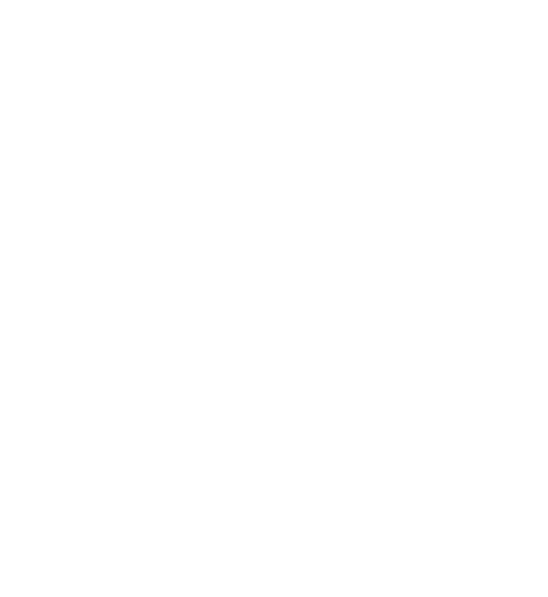

interactive(children=(Dropdown(description='file', options=('Predicted_0498_test.tif', '1502_test.tif', '0529_…

In [7]:

# ------------------------------- User input -------------------------------
#@markdown ### Data parameters
Data_folder = "DEEPSTORM_test_data_infinite_SNR/" #@param {type:"string"}
Result_folder = "DEEPSTORM_test_data_infinite_SNR" #@param {type:"string"}
#@markdown Get pixel size from file?
get_pixel_size_from_file = False #@param {type:"boolean"}
#@markdown Otherwise, use this value (in nm):
pixel_size = 66 #@param {type:"number"}

#@markdown ### Model parameters
#@markdown Do you want to use the model you just trained?
Use_the_current_trained_model = True #@param {type:"boolean"}
#@markdown Otherwise, please provide path to the model folder below
prediction_model_path = "models_infinite_SNR/test/weights_best.hdf5" #@param {type:"string"}

#@markdown ### Prediction parameters
batch_size =  4#@param {type:"integer"}

#@markdown ### Post processing parameters
threshold =  0.1#@param {type:"number"}
neighborhood_size =  5#@param {type:"integer"}
#@markdown Do you want to locally average the model output with CoG estimator ?
use_local_average = True #@param {type:"boolean"}


if get_pixel_size_from_file:
  pixel_size = None

if (Use_the_current_trained_model): 
  prediction_model_path = os.path.join(model_path, model_name)

if os.path.exists(prediction_model_path):
  print("The "+os.path.basename(prediction_model_path)+" model will be used.")
else:
  print(bcolors.WARNING+'!! WARNING: The chosen model does not exist !!'+bcolors.NORMAL)
  print('Please make sure you provide a valid model path before proceeding further.')

# inform user whether local averaging is being used
if use_local_average == True: 
  print('Using local averaging')

if not os.path.exists(Result_folder):
  print('Result folder was created.')
  os.makedirs(Result_folder)


# ------------------------------- Run predictions -------------------------------

start = time.time()
#%% This script tests the trained fully convolutional network based on the 
# saved training weights, and normalization created using train_model.

if os.path.isdir(Data_folder): 
  for filename in list_files(Data_folder, 'tif'):
    # run the testing/reconstruction process
    print("------------------------------------")
    print("Running prediction on: "+ filename)
    batchFramePredictionLocalization(Data_folder, filename, prediction_model_path, Result_folder, 
                                     batch_size, 
                                     threshold, 
                                     neighborhood_size, 
                                     use_local_average,
                                     pixel_size = pixel_size)

elif os.path.isfile(Data_folder):
    batchFramePredictionLocalization(os.path.dirname(Data_folder), os.path.basename(Data_folder), prediction_model_path, Result_folder, 
                                   batch_size, 
                                   threshold, 
                                   neighborhood_size, 
                                   use_local_average, 
                                   pixel_size = pixel_size)



print('--------------------------------------------------------------------')
# Displaying the time elapsed for training
dt = time.time() - start
minutes, seconds = divmod(dt, 60) 
hours, minutes = divmod(minutes, 60) 
print("Time elapsed:",hours, "hour(s)",minutes,"min(s)",round(seconds),"sec(s)")


# ------------------------------- Interactive display -------------------------------

print('--------------------------------------------------------------------')
print('---------------------------- Previews ------------------------------')
print('--------------------------------------------------------------------')

if os.path.isdir(Data_folder): 
  @interact
  def show_QC_results(file = list_files(Data_folder, 'tif')):

    plt.figure(figsize=(15,7.5))
    # Wide-field
    plt.subplot(1,2,1)
    plt.axis('off')
    img_Source = io.imread(os.path.join(Result_folder, 'Widefield_'+file))
    plt.imshow(img_Source, norm = simple_norm(img_Source, percent = 99.5))
    plt.title('Widefield', fontsize=15)
    # Prediction
    plt.subplot(1,2,2)
    plt.axis('off')
    img_Prediction = io.imread(os.path.join(Result_folder, 'Predicted_'+file))
    plt.imshow(img_Prediction, norm = simple_norm(img_Prediction, percent = 99.5))
    plt.title('Predicted',fontsize=15)

if os.path.isfile(Data_folder):

  plt.figure(figsize=(15,7.5))
  # Wide-field
  plt.subplot(1,2,1)
  plt.axis('off')
  img_Source = io.imread(os.path.join(Result_folder, 'Widefield_'+os.path.basename(Data_folder)))
  plt.imshow(img_Source, norm = simple_norm(img_Source, percent = 99.5))
  plt.title('Widefield', fontsize=15)
  # Prediction
  plt.subplot(1,2,2)
  plt.axis('off')
  img_Prediction = io.imread(os.path.join(Result_folder, 'Predicted_'+os.path.basename(Data_folder)))
  plt.imshow(img_Prediction, norm = simple_norm(img_Prediction, percent = 99.5))
  plt.title('Predicted',fontsize=15)

